In [1]:
!pip install -U scikit-learn -q
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db -q
!pip install sweetviz -q
!pip install stringcase -q
!pip install phik -q
!pip install optuna -q
!pip install shap -q
!pip install matplotlib==3.4 -q # немношк обновим, что б графики сделать покрасивее(было 3.3.4)
!pip install optuna-integration[sklearn] -q

# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

### Описание услуг

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

### Описание данных

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

Таблица contract
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.
- Информация о договорах актуальна на 1 февраля 2020.

### Основные задачи:

- разработать модель, предсказывающую разорвет ли абонет договор,
- целевая метрика ROC-AUC должна быть не менее 0.85. Для интерпретируемости модели дополнительно выведите значение accuracy,
- предложить способы для дальнейшего улучшения модели и дайть бизнес-рекомендации заказчику.

In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db 
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 
query = '''
SELECT *
FROM data_arc
LIMIT 10
''' 

arc = pd.read_sql_query(query, con = engine)

--2025-03-27 13:24:50--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.38’

ds-plus-final.db.38 100%[===================>]   3.42M  --.-KB/s    in 0.07s   

2025-03-27 13:24:51 (51.4 MB/s) - ‘ds-plus-final.db.38’ saved [3588096/3588096]



## Импорты, константы и доп. функции

In [3]:
import os
import time
import stringcase

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import sweetviz as sv
from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sqlalchemy import create_engine, inspect
from optuna.integration import OptunaSearchCV
from optuna.distributions import (
    CategoricalDistribution,
    FloatDistribution,
    IntDistribution,
)
from optuna.samplers import RandomSampler

In [4]:
RANDOM_STATE = 170325
TEST_SIZE = 0.25
LOAD_DATE = '01-02-2020'

In [5]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [6]:
# подключаемся к бд
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

In [6]:
def cross_params(cross_seach):
    """Визуализация параметров кросс-валидации"""
    df_cg=pd.DataFrame(cross_seach.cv_results_)[
    ['rank_test_score', 'mean_test_score','params', 'mean_fit_time']
    ].sort_values('rank_test_score')[:5].reset_index(drop=True)
    print("Парамерты лучшей модели",cross_seach.best_params_)
    print("ROC-AUC с лучшими гиперпараметрами на кросс-валидации :", cross_seach.best_score_)
    display(df_cg)

In [7]:
def model_score(model, X_test, y_test):
    """Оценка производительности модели на тестовой выборке"""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,7), dpi=100)
    y_pred = model.predict(X_test)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    preds = model.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=axes[1])
    axes[1].plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
    axes[1].set_title("График ROC-AUC")
    axes[1].legend()
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="CatBoostClassifier",ax=axes[2])
    axes[2].set_title("Кривая полноты и точности")
    axes[2].legend()

    roc_auc = roc_auc_score(y_test, preds)
    
    print('ROC-AUC = ', roc_auc)
    print('Accuracy  = ', accuracy_score(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))

## Загрузка данных

In [7]:
# Создаём инспектор для получения метаданных базы данных
inspector = inspect(engine)

# Получаем список всех таблиц в базе данных
table_names = inspector.get_table_names()

In [8]:
dataframes = {}
for table_name in table_names:
    try:
        #выберем по именам блиц, а то у нас там 2 проекта лежат
        if table_name in ('contract', 'personal', 'internet', 'phone'):
            query = f"SELECT * FROM {table_name}" 
            df = pd.read_sql(query, engine)  
            dataframes[table_name] = df  
    except:
        print("Таблицы не найдены")

# Смотрим все ли нашли
for table_name, df in dataframes.items():
    print(f"Таблица: {table_name}")
    globals()[f'df_{table_name}'] = df
    print()
    display(df.head())
    print()

Таблица: contract



customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  
0           Electronic check          29.85        31.04  
1               Mailed check          56.95      2071.84  
2               Mailed check          53.85       226.17  
3  Bank transfer (automatic)           42.3       1960.6  
4           Electronic check           70.7        353.5


Таблица: internet



customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No


Таблица: personal



customerID  gender SeniorCitizen Partner Dependents
0  7590-VHVEG  Female             0     Yes         No
1  5575-GNVDE    Male             0      No         No
2  3668-QPYBK    Male             0      No         No
3  7795-CFOCW    Male             0      No         No
4  9237-HQITU  Female             0      No         No


Таблица: phone



CustomerId MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

**Промежуточные выводы:**
- все искомые таблицы найдены и соответствуют условию задачи,
- все таблицы содержат данные.

## Общий анализ данных

### Данные df_contract

In [9]:
#перейдем к змеиному регистру это симпатичнее
df_contract.rename(columns=lambda x: stringcase.snakecase(x), inplace=True)

In [10]:
for col in df_contract.columns:
    print(f'Колонка {col} - тип данных -{df_contract[col].dtype}')

Колонка customer_i_d - тип данных -object
Колонка begin_date - тип данных -object
Колонка end_date - тип данных -object
Колонка type - тип данных -object
Колонка paperless_billing - тип данных -object
Колонка payment_method - тип данных -object
Колонка monthly_charges - тип данных -object
Колонка total_charges - тип данных -object


In [11]:
# поправим некрасивый момент
df_contract = df_contract.rename(columns={'customer_i_d': 'customer_id',})
# поменяем типы данных для упрощения анализа
df_contract.begin_date = pd.to_datetime(df_contract.begin_date, errors='coerce')
df_contract.end_date = pd.to_datetime(df_contract.end_date, errors='coerce')
df_contract.monthly_charges = pd.to_numeric(df_contract.monthly_charges, errors='coerce')
df_contract.total_charges = pd.to_numeric(df_contract.total_charges, errors='coerce')

                                             |          | [  0%]   00:00 -> (? left)


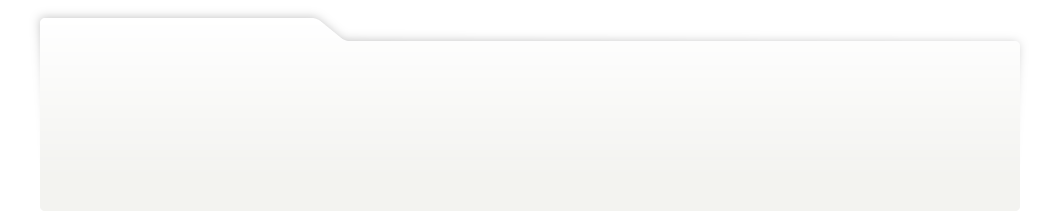
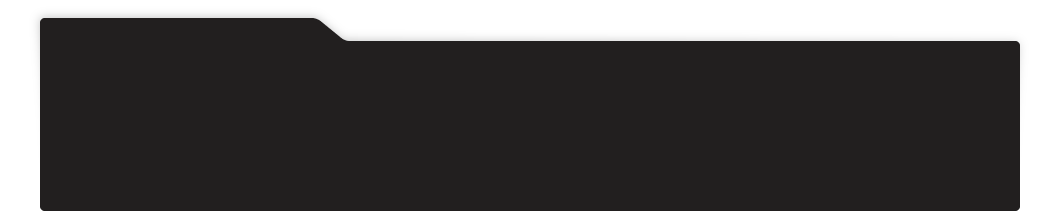
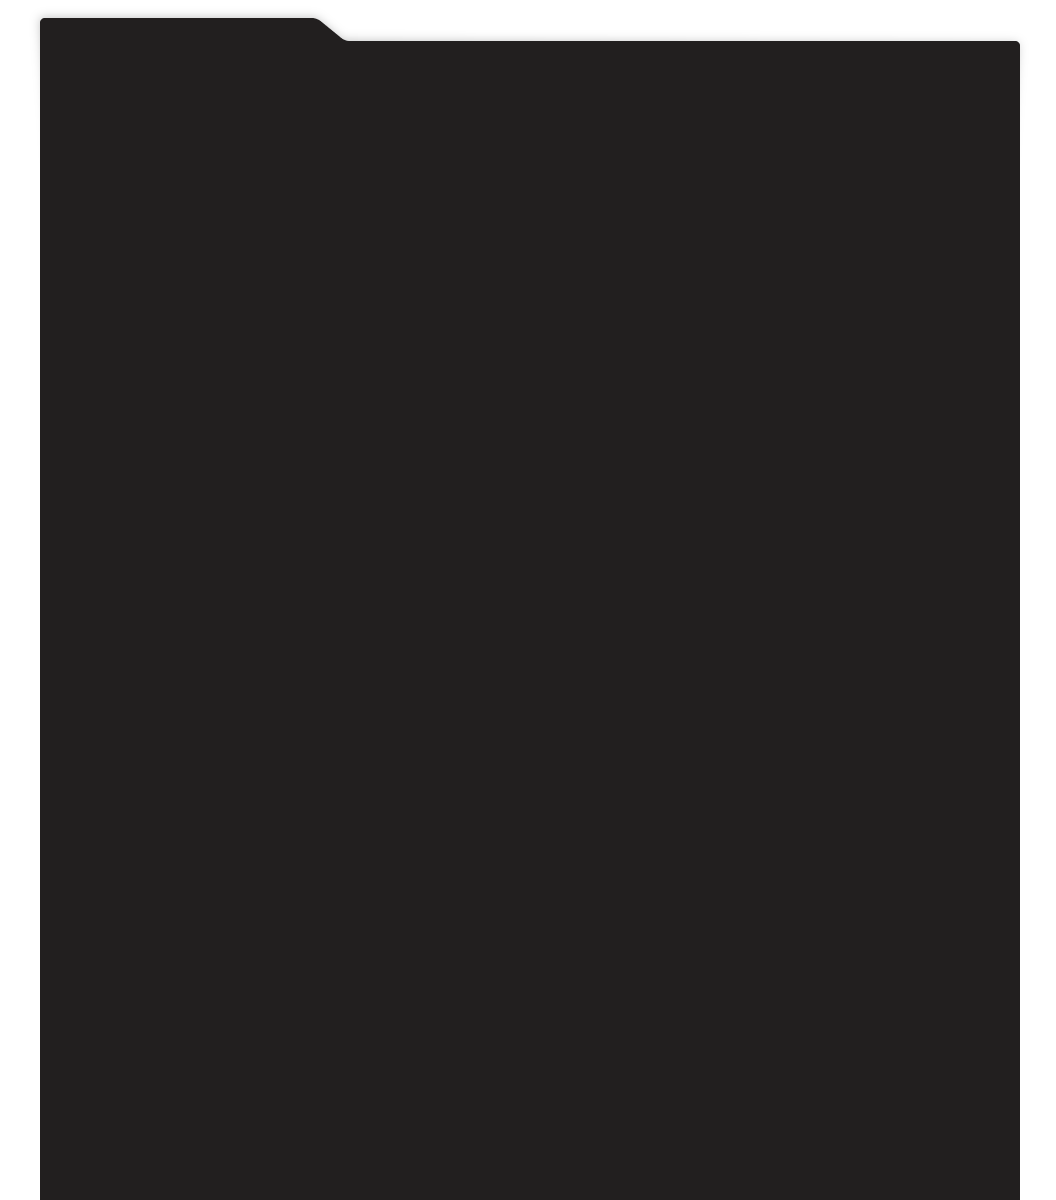
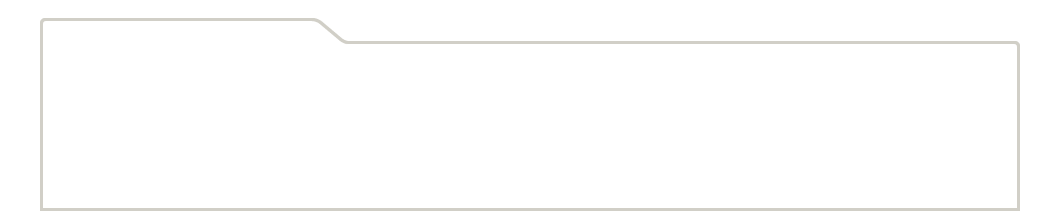
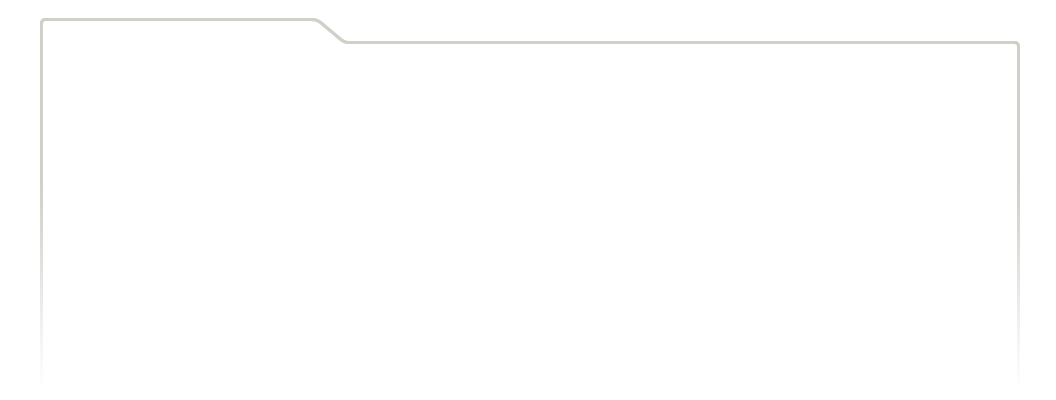
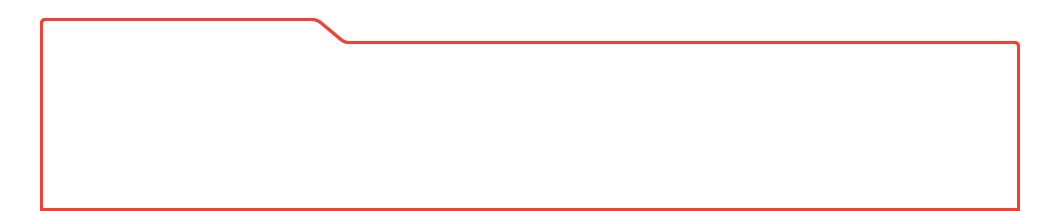
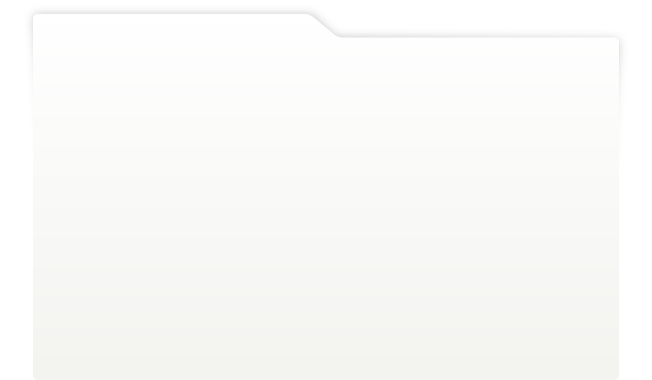
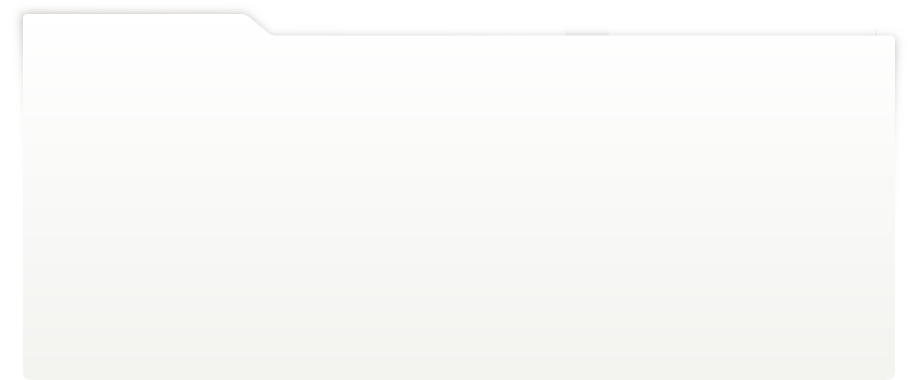
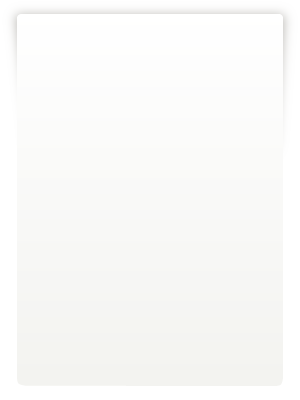
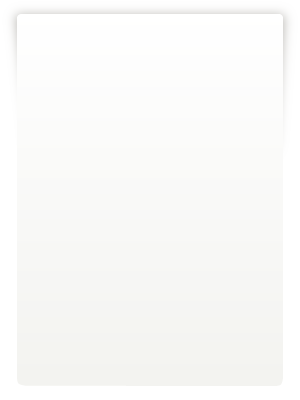
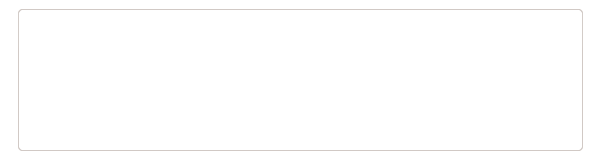
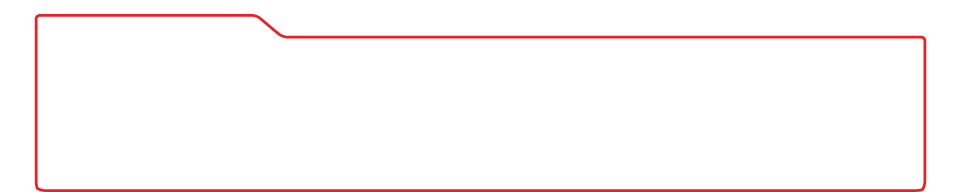
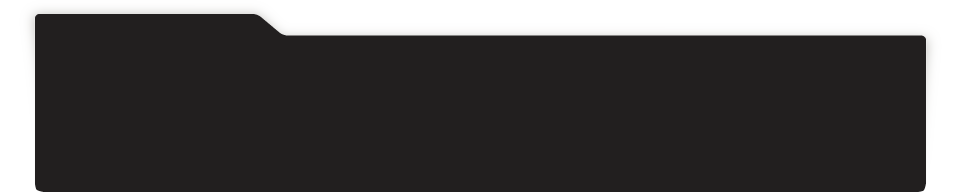
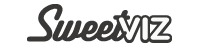
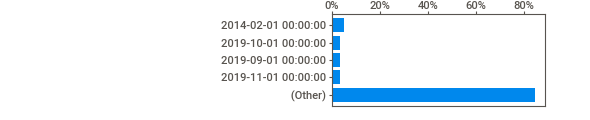
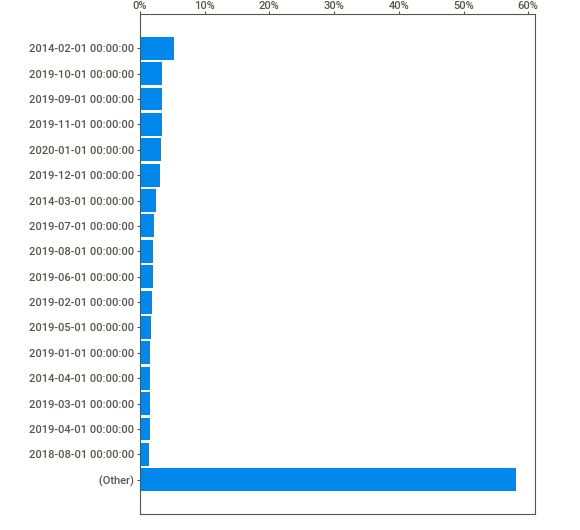
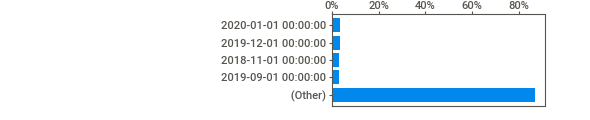
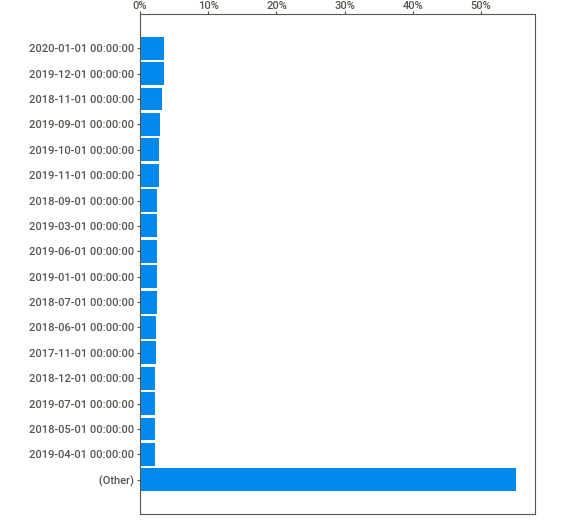
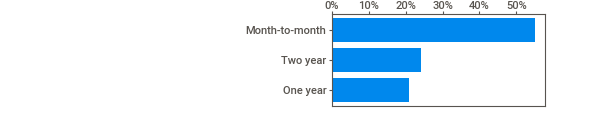
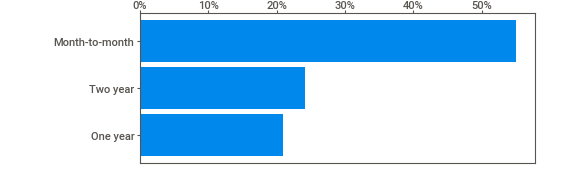
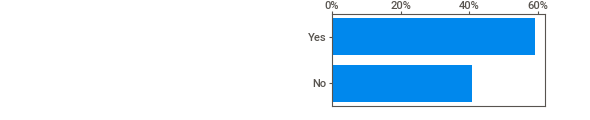
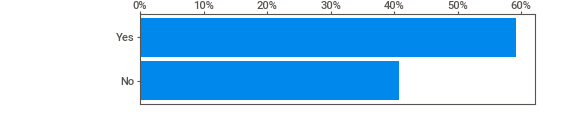
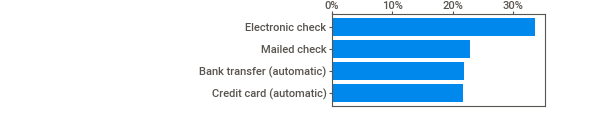
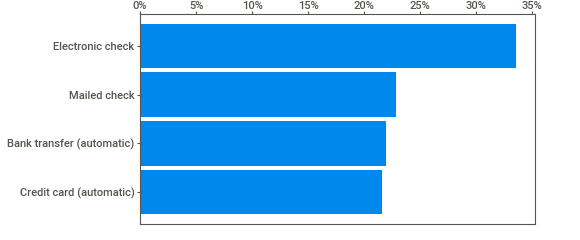
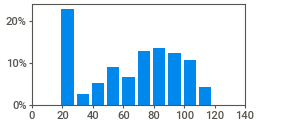
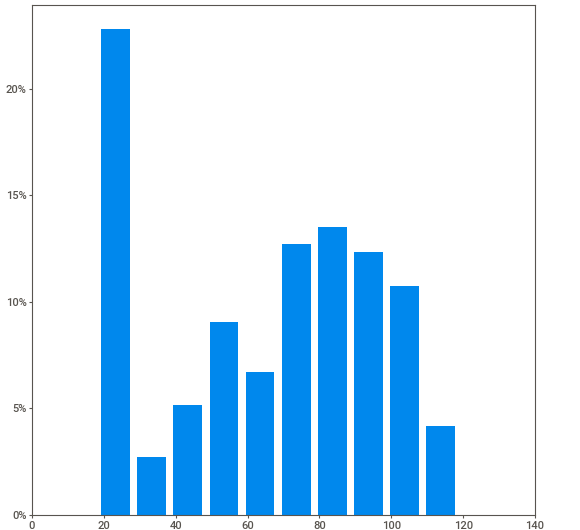
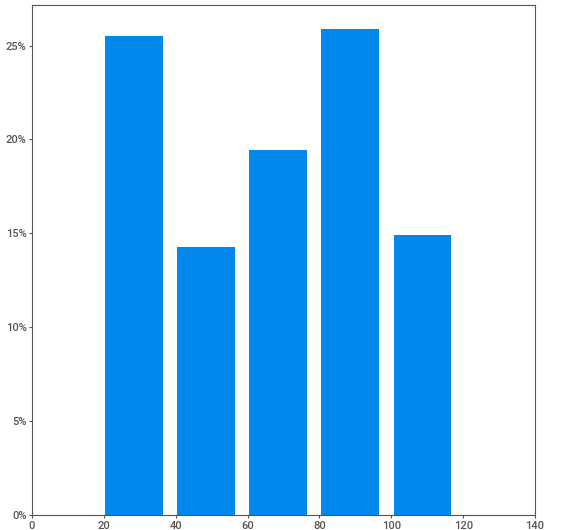
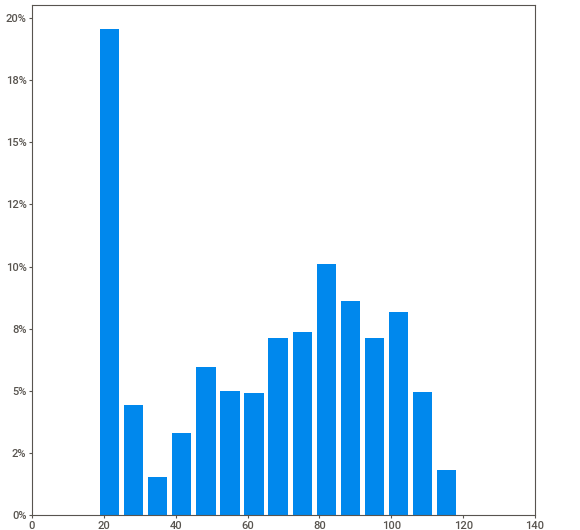
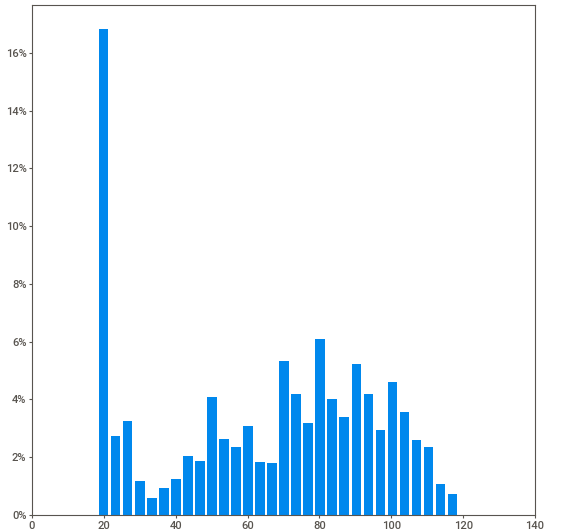
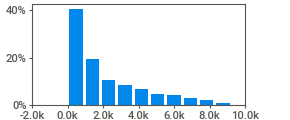
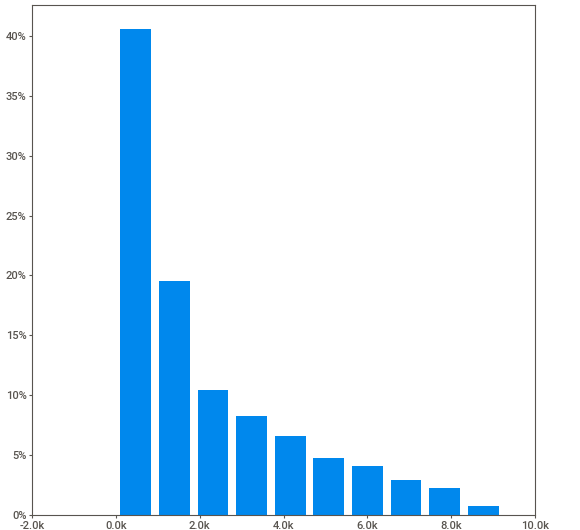
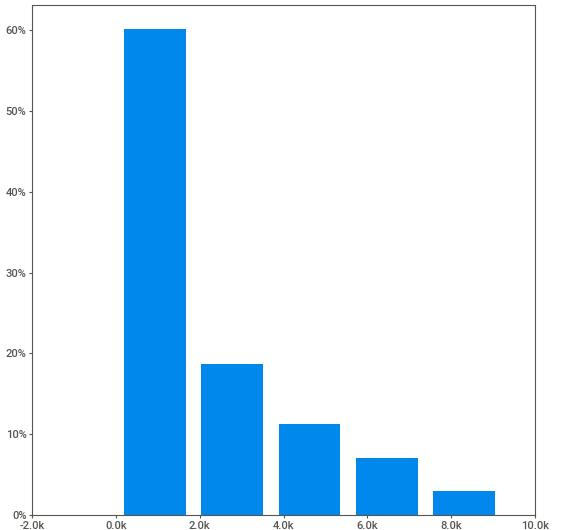
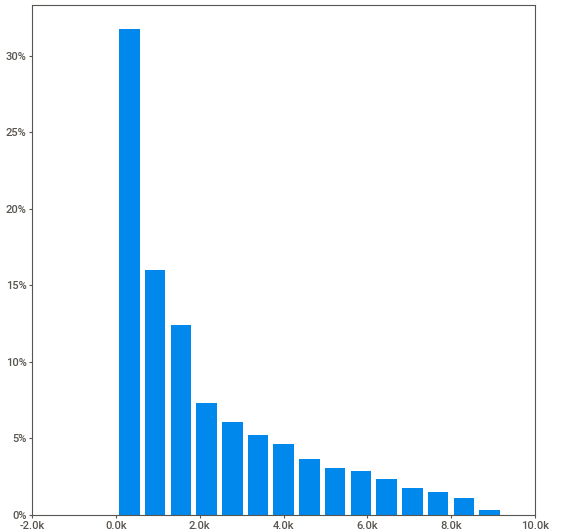
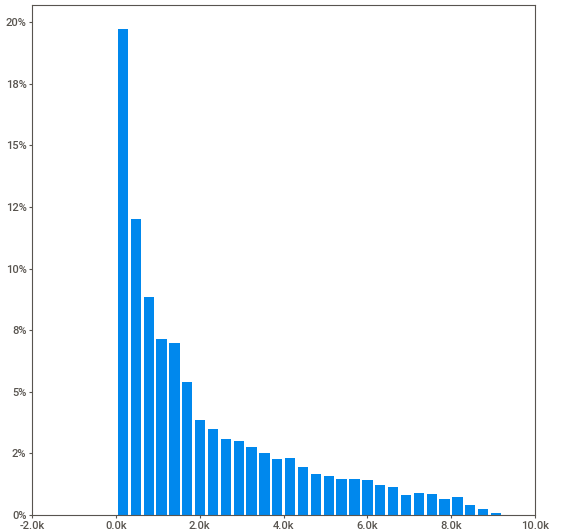
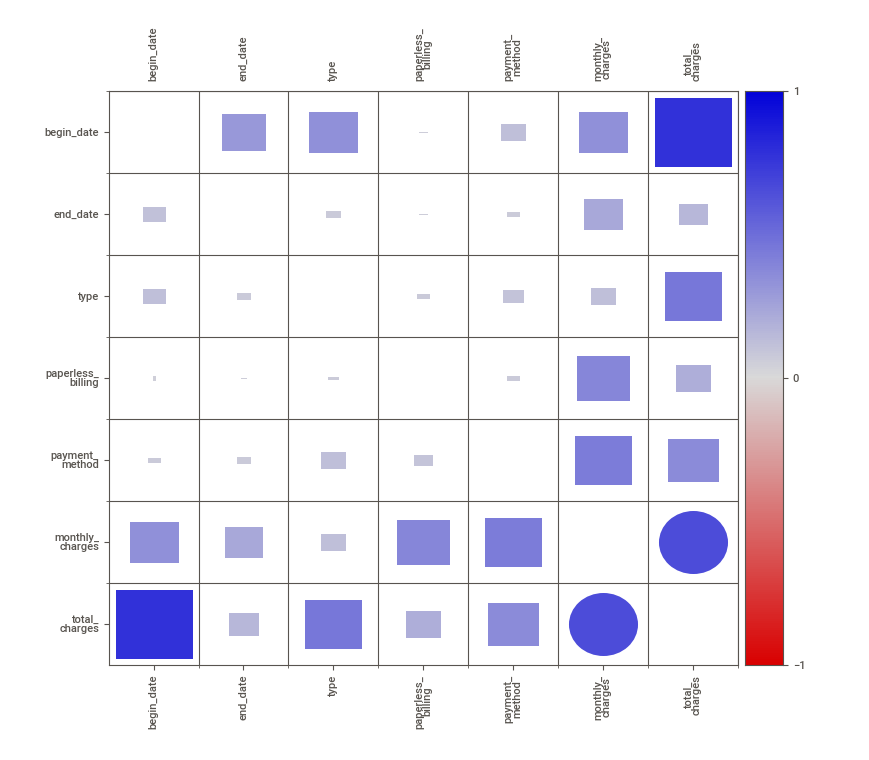
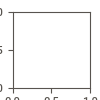

In [26]:
report_0 = sv.analyze([df_contract, "Данные о контрактах"])
report_0.show_notebook()

In [14]:
df_contract[df_contract.total_charges=='']

Empty DataFrame
Columns: [customer_id, begin_date, end_date, type, paperless_billing, payment_method, monthly_charges, total_charges]
Index: []

**Промежуточные выводы:**
- привели названия колонок к змеиному регистру,
- уточнили типизацию колонок,
- имеем 7043 наблюдений без полных дубликатов,
- 77 различных дат заключения договоров, все даты начинаются с первого дня месяца, пропущенных дат нет,
- дата завершения договора заполнена только в 16% случаев, значит прочие 84% договоров еще действуют, оставим эти пропуски для дальнейшей обработки и создания целевого признака,
- три типа договоров, самый распространенный с помесячной оплатой (55%),
- бумажный чек желают иметь 59% пользователей,
- оплата может быть произведена 4 путями, самый популярный - электронный чек(34%),
- месячный платеж весьма вариативен (1585 вариантов), в среднем около 65 единиц, самый распространенный около 20 единиц, распределение не похоже на нормальное,
- общая сумма платежей вариативна, в среднем около 2000 единиц,есть небольшое количество пропусков (менее 1%), посмотрим в дальнейшем их соотношение с датами,распределение не похоже на нормальное,
- в целом потерянных данных нет, типизацию поправили, для дальнешей работы данные готовы.

### Данные df_internet

In [12]:
df_internet.rename(columns=lambda x: stringcase.snakecase(x), inplace=True)
# поправим некрасивый момент
df_internet = df_internet.rename(columns={'customer_i_d': 'customer_id',})

In [13]:
for col in df_internet.columns:
    print(f'Колонка {col} - тип данных -{df_internet[col].dtype}')

Колонка customer_id - тип данных -object
Колонка internet_service - тип данных -object
Колонка online_security - тип данных -object
Колонка online_backup - тип данных -object
Колонка device_protection - тип данных -object
Колонка tech_support - тип данных -object
Колонка streaming_t_v - тип данных -object
Колонка streaming_movies - тип данных -object


                                             |          | [  0%]   00:00 -> (? left)


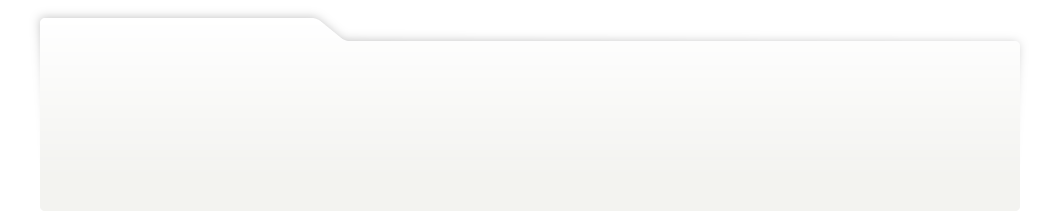
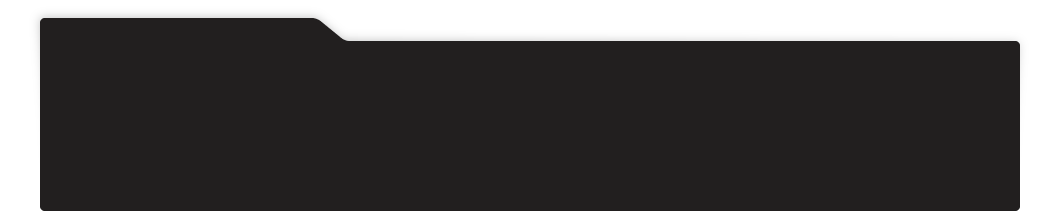
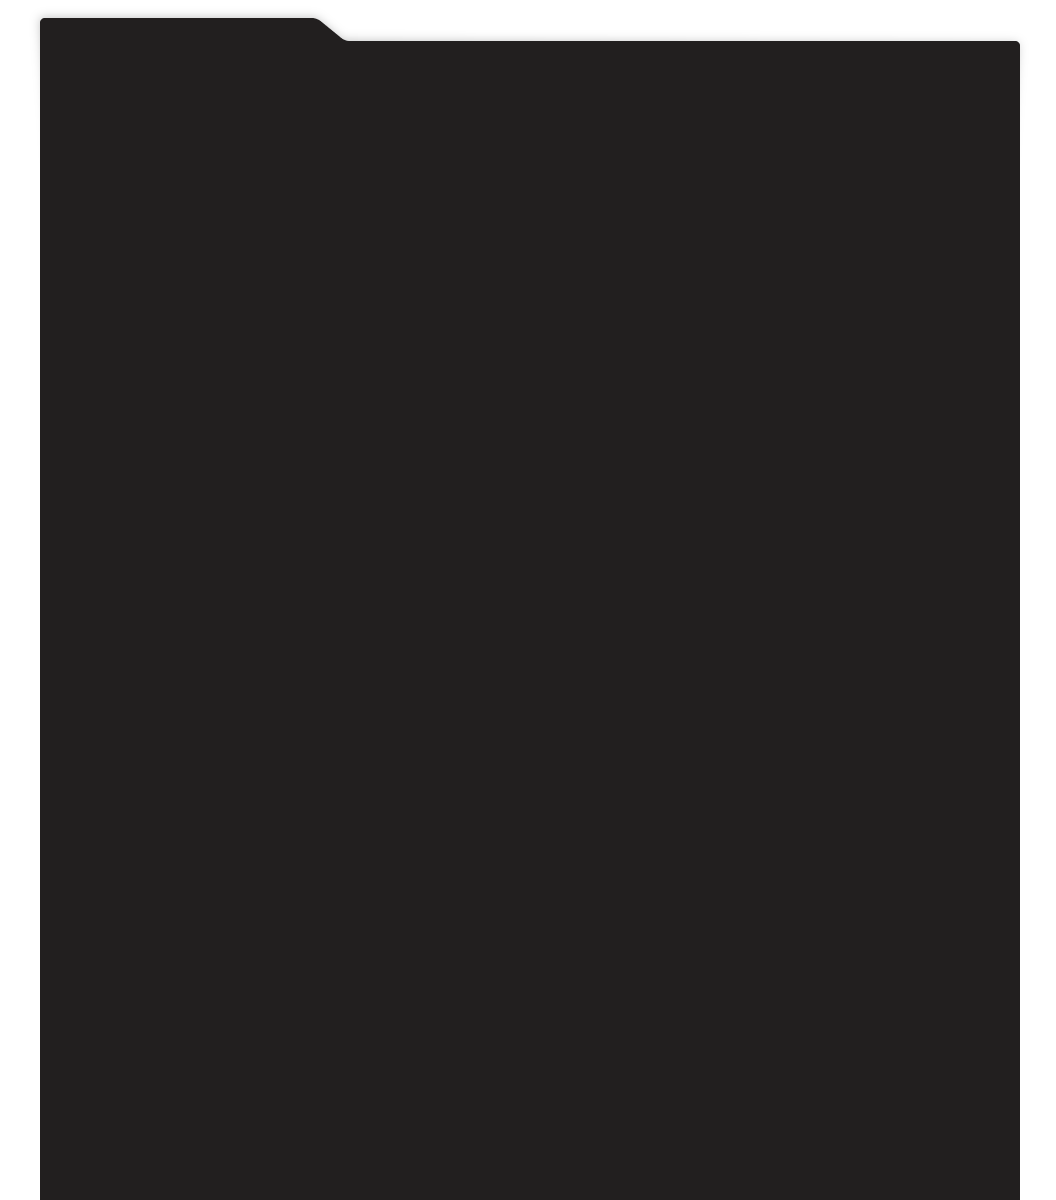
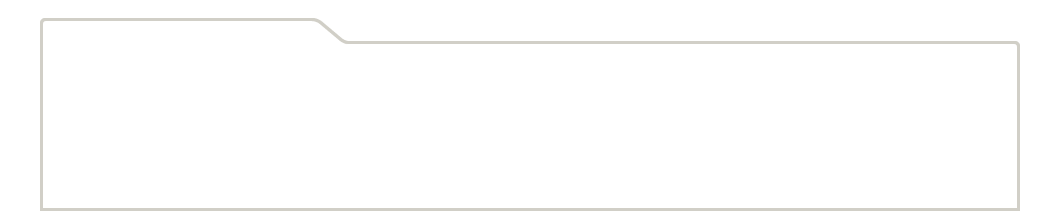
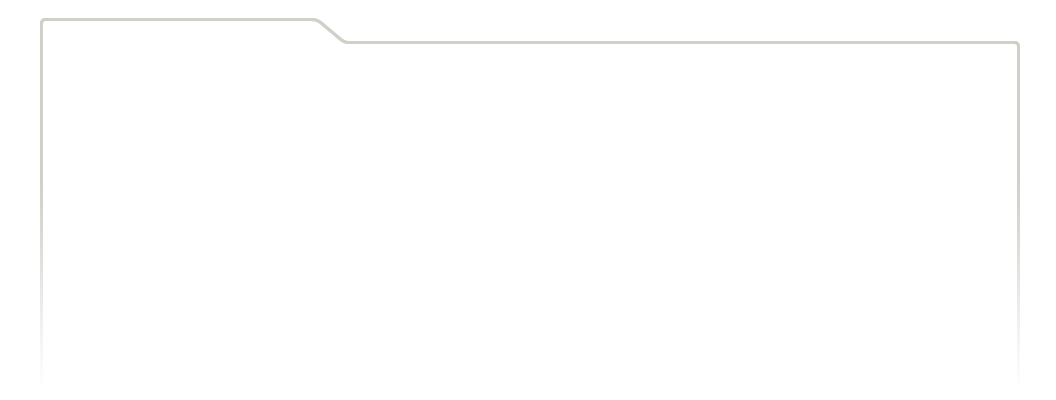
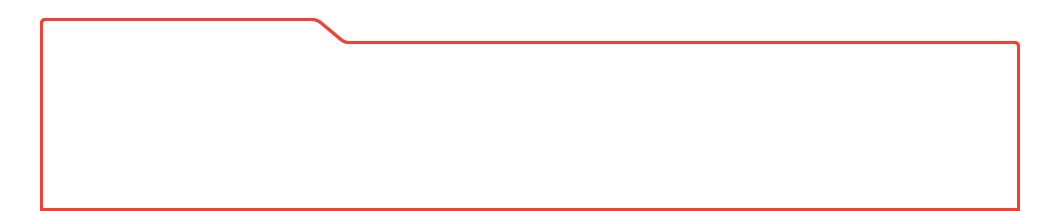
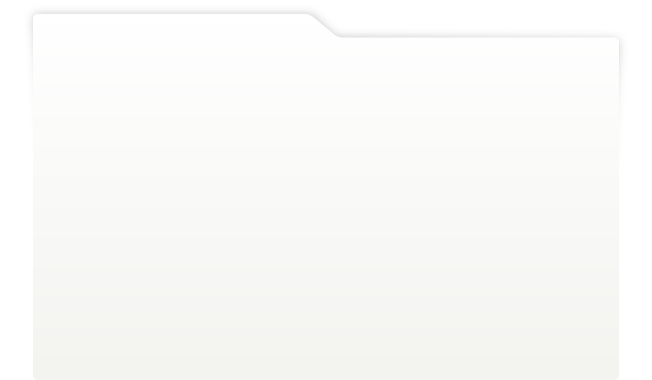
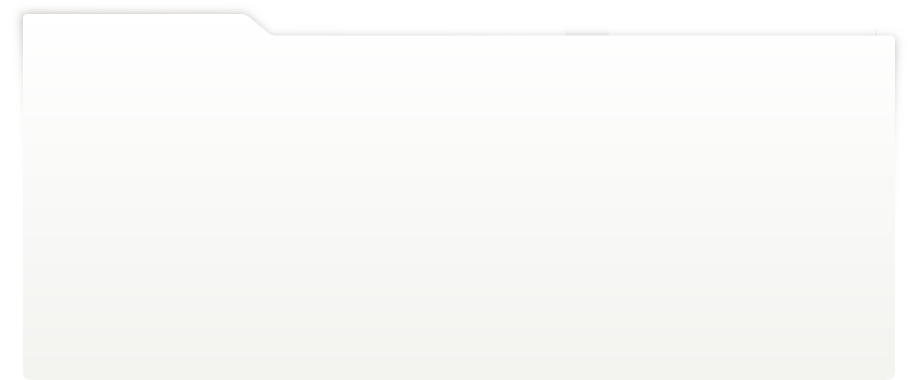
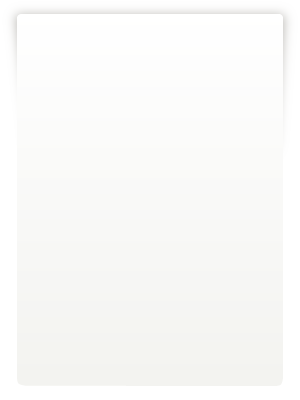
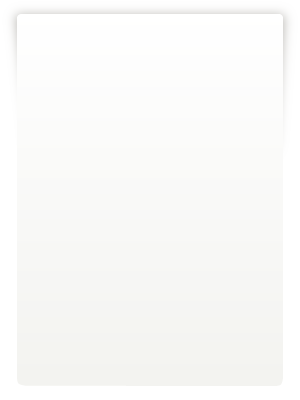
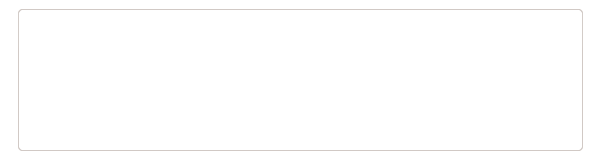
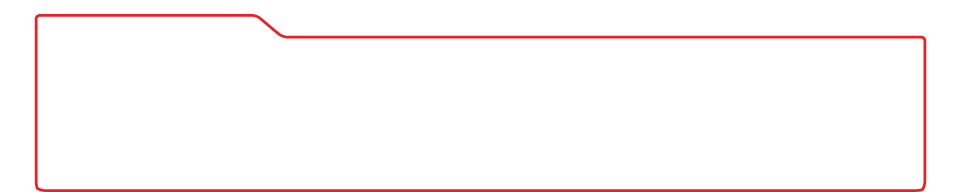
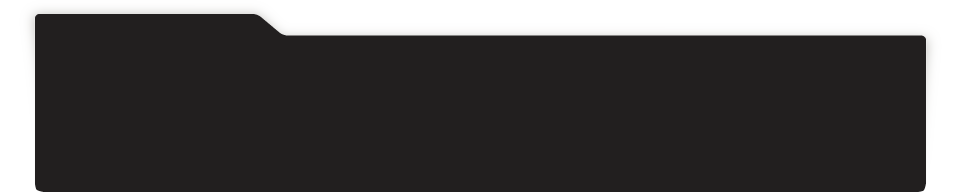
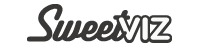
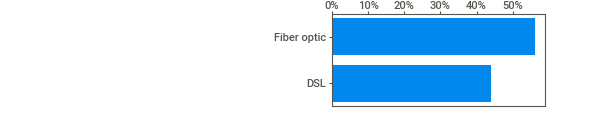
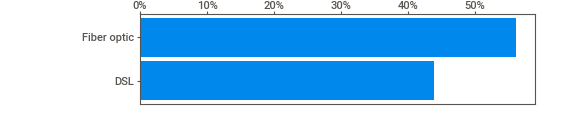
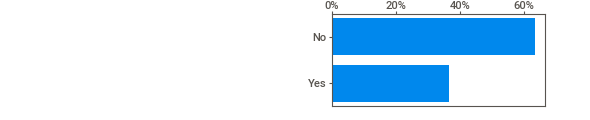
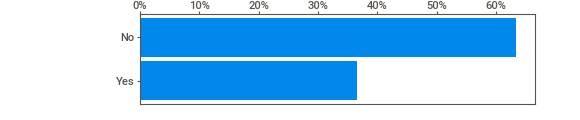
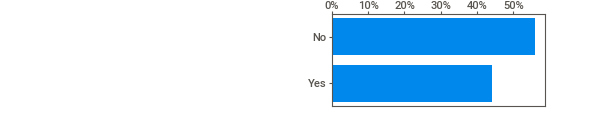
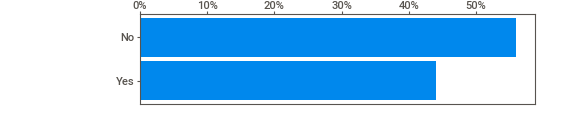
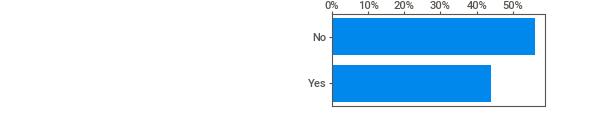
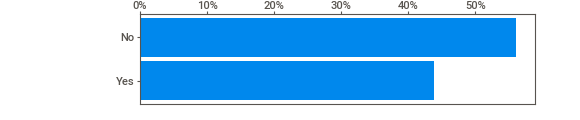
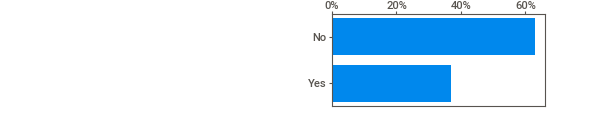
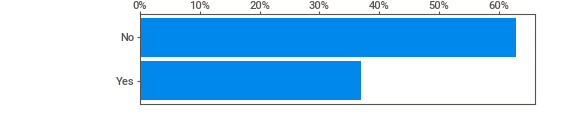
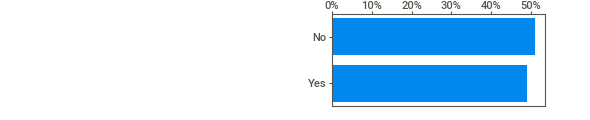
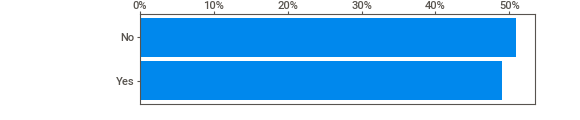
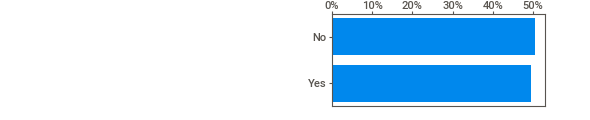
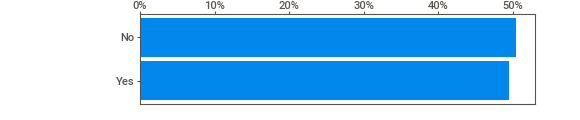
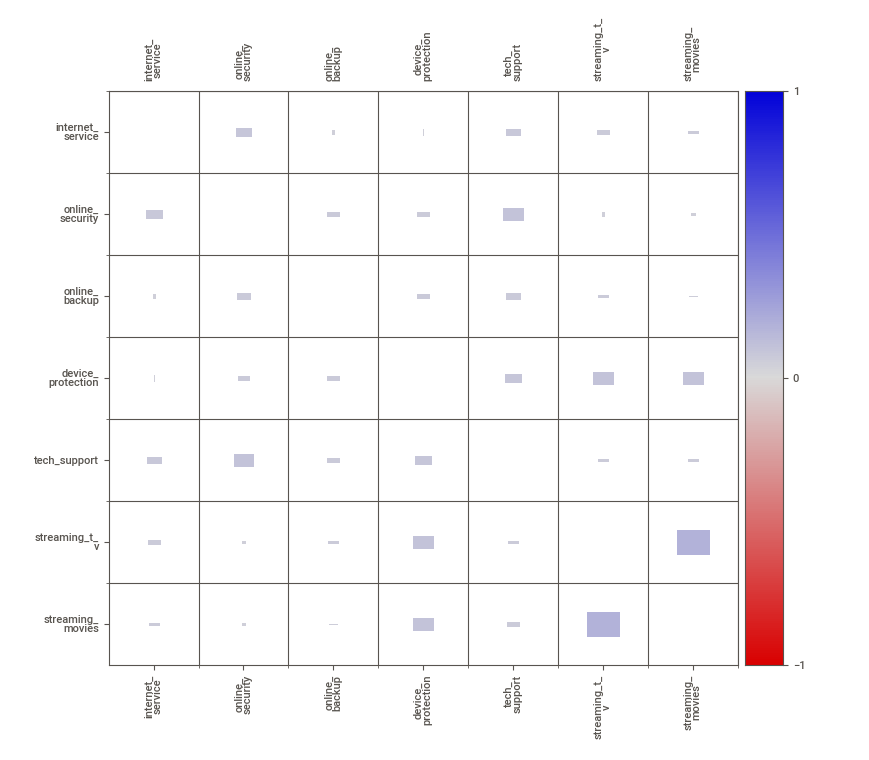
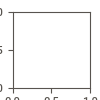

In [17]:
report_1 = sv.analyze([df_internet, "Данные по интернету"])
report_1.show_notebook()

**Промежуточные выводы:**
- привели названия колонок к змеиному регистру,
- уточнили типизацию колонок,
- имеем 5517 наблюдений без дубликатов, количество наблюдей меньше чем число пользователей - видимо не все пользуются услугой интернета,
- имеем 2 типа подключения, более популярный оптоволокно(56%),
- большая часть пользователей не пользуется блокировкой вредноносных сайтов(63%),
- большая часть пользователей не пользуется облачным хранилищем(56%),
- большая часть пользователей не пользуется облачным антивирусом(56%),
- большая часть пользователей не пользуется выделенной линией тех поддержки(63%),
- пользователей пользующихся стриминговым тв чуть больше 51%, но незначительно,
- каталогом фильмов пользуются 50% пользователей,
- пропусков в данных нет, типизацию корректировать не надо.

### Данные df_personal

In [14]:
df_personal.rename(columns=lambda x: stringcase.snakecase(x), inplace=True)
# поправим некрасивый момент
df_personal = df_personal.rename(columns={'customer_i_d': 'customer_id',})

In [15]:
for col in df_personal.columns:
    print(f'Колонка {col} - тип данных -{df_personal[col].dtype}')

Колонка customer_id - тип данных -object
Колонка gender - тип данных -object
Колонка senior_citizen - тип данных -object
Колонка partner - тип данных -object
Колонка dependents - тип данных -object


                                             |          | [  0%]   00:00 -> (? left)


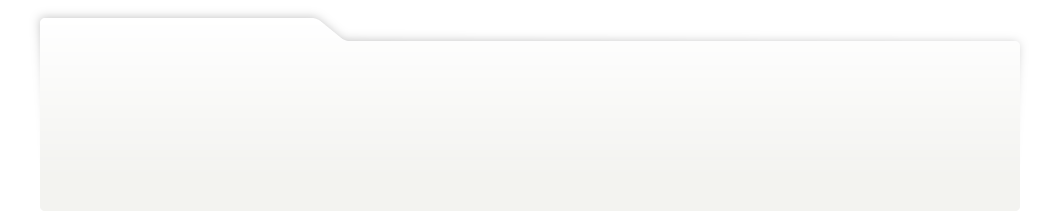
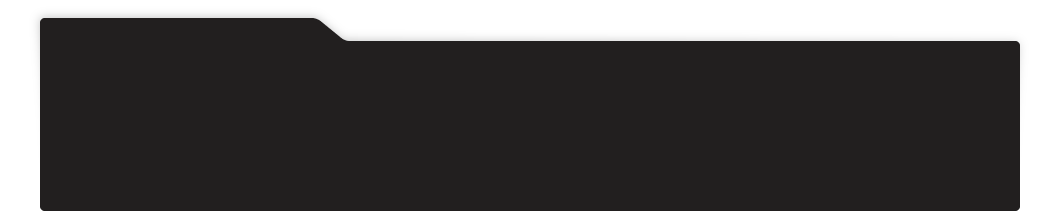
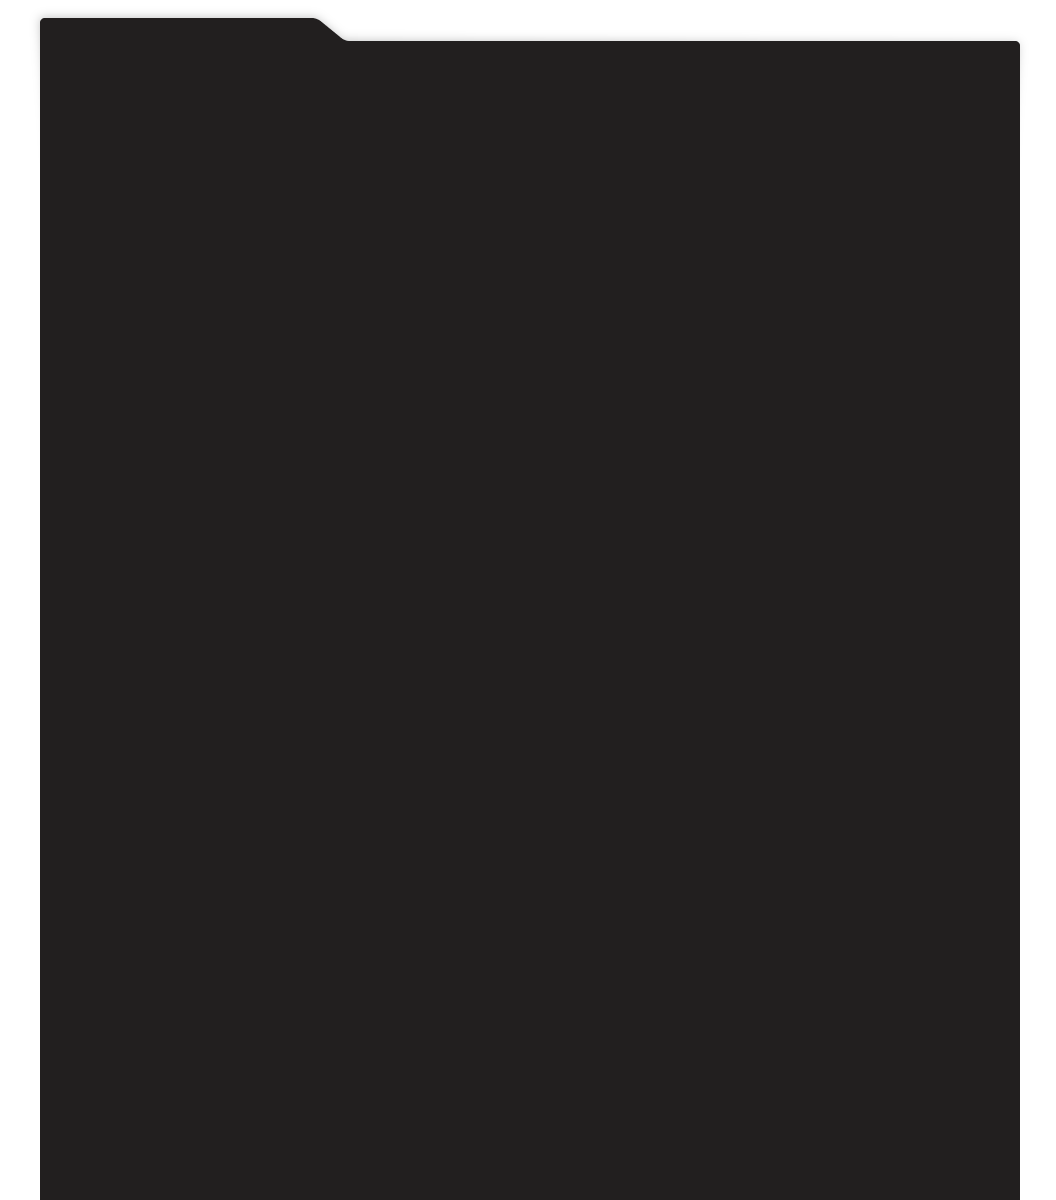
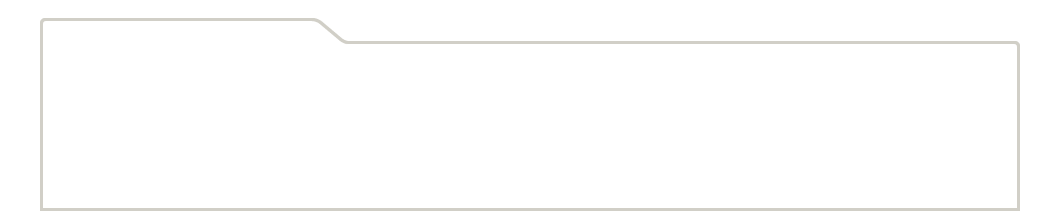
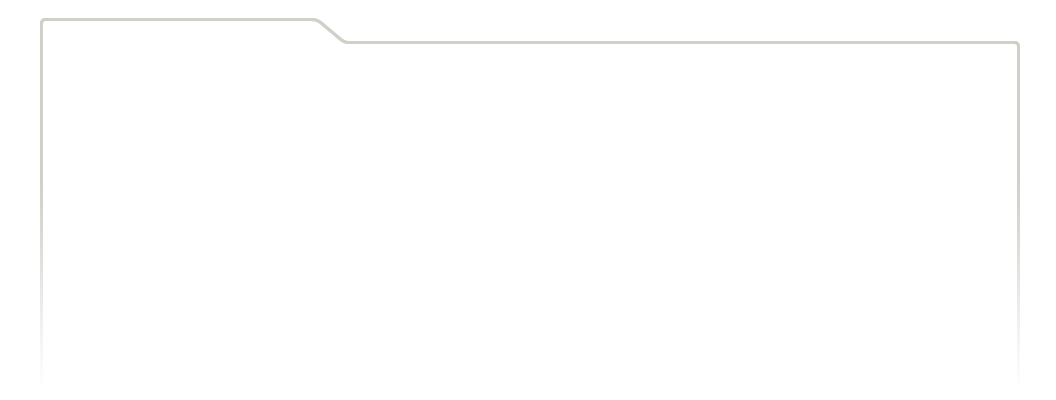
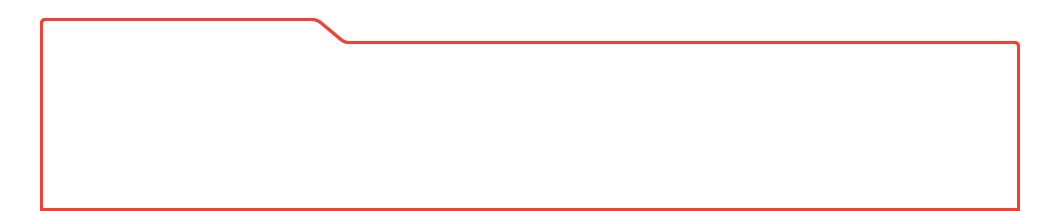
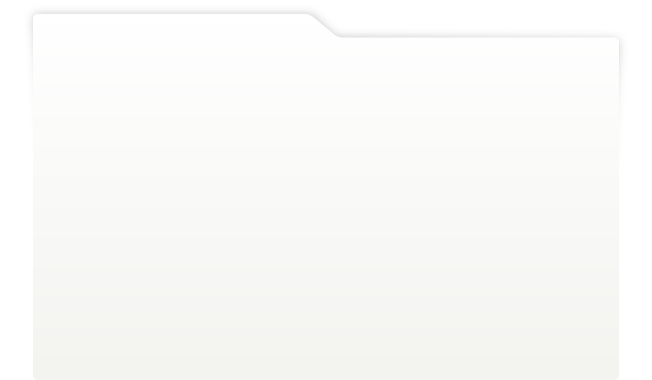
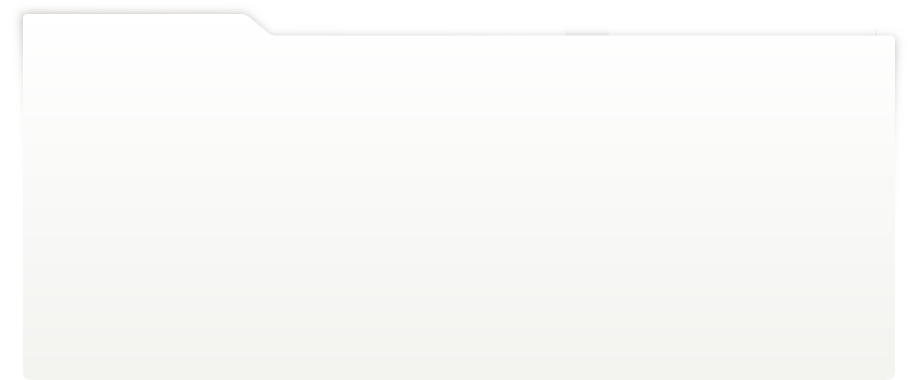
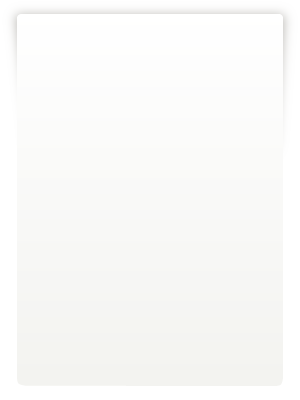
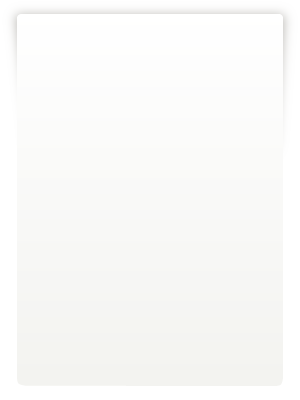
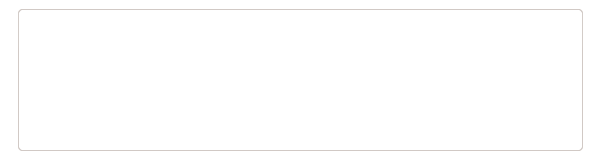
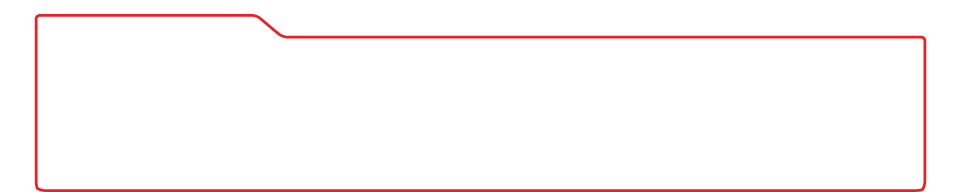
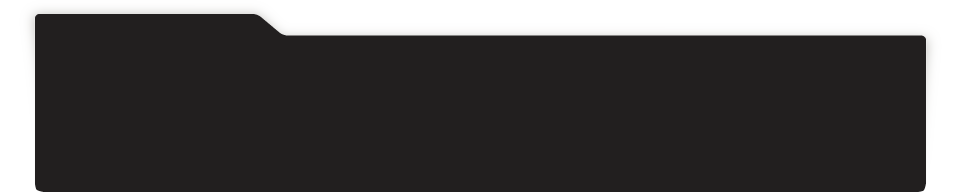
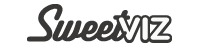
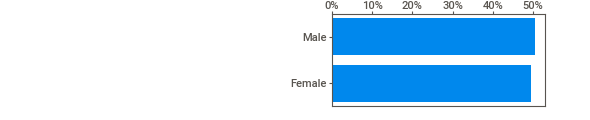
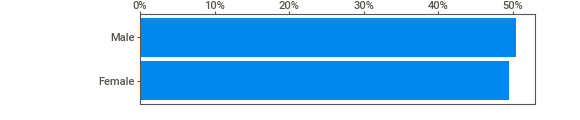
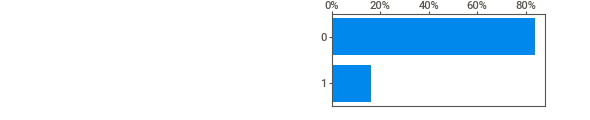
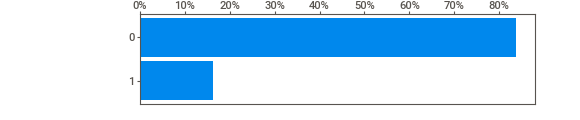
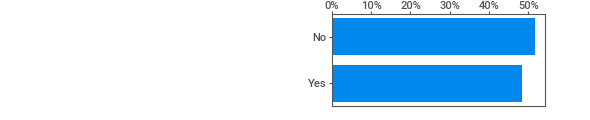
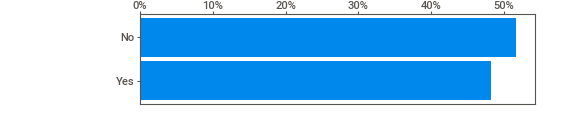
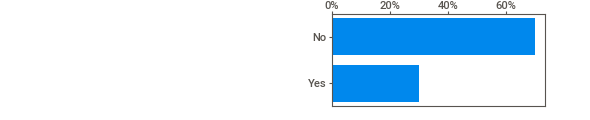
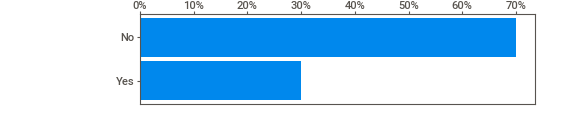
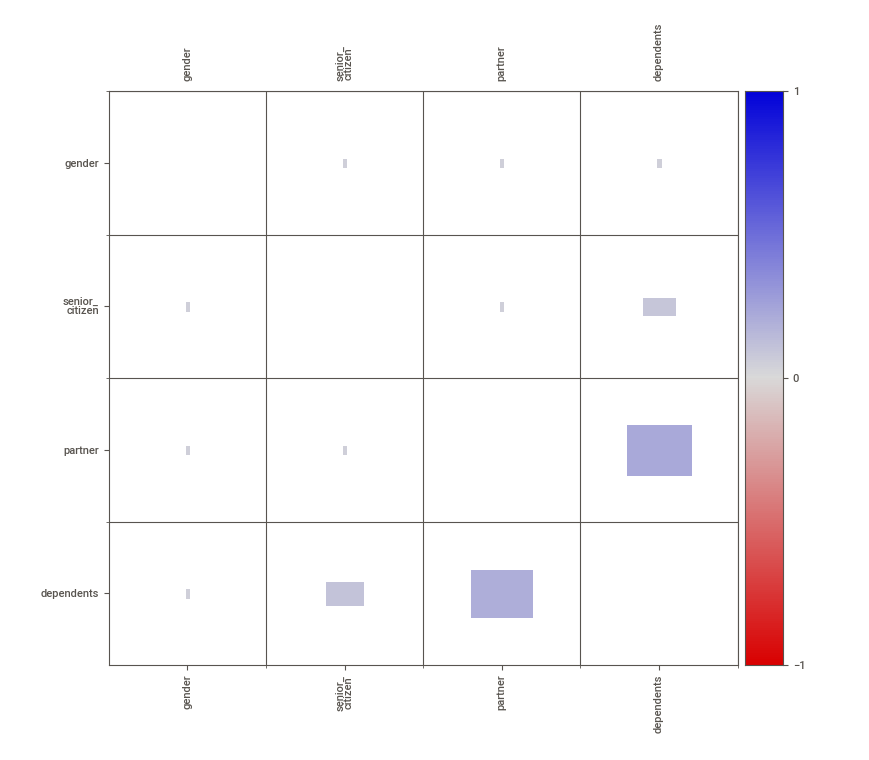
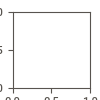

In [20]:
report_2 = sv.analyze([df_personal, "Персональные данные"])
report_2.show_notebook()

**Промежуточные выводы:**
- привели названия колонок к змеиному регистру,
- уточнили типизацию колонок,
- имеем 7043 наблюдений без дубликатов, количество наблюдей сответствует числу договоров из первого файла,
- разделение по полу 50%,
- пенсионеров среди пользователей 16%,
- не состоящих в браке чуть больше 52%,
- большая часть пользователей не имеет детей 70%
- пропусков нет, типизация корректна.

### Данные df_phone

In [16]:
df_phone.rename(columns=lambda x: stringcase.snakecase(x), inplace=True)
# поправим некрасивый момент
df_phone = df_phone.rename(columns={'customer_i_d': 'customer_id',})

                                             |          | [  0%]   00:00 -> (? left)


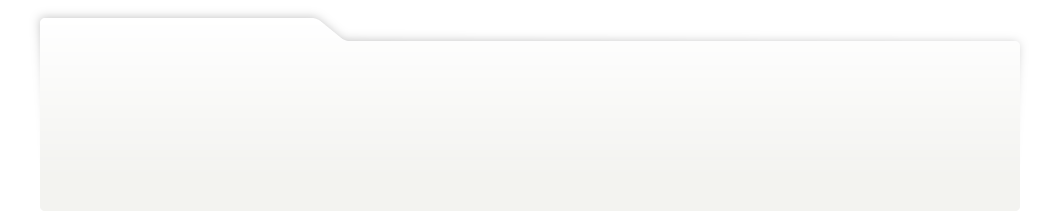
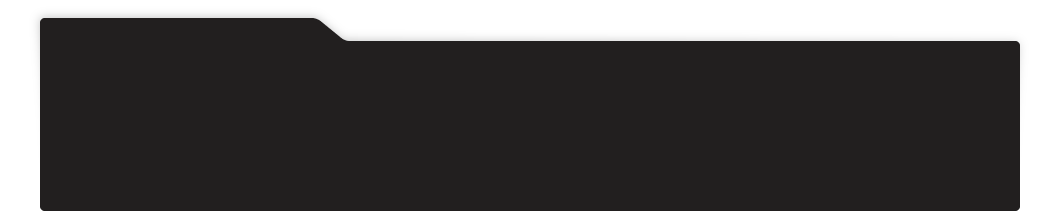
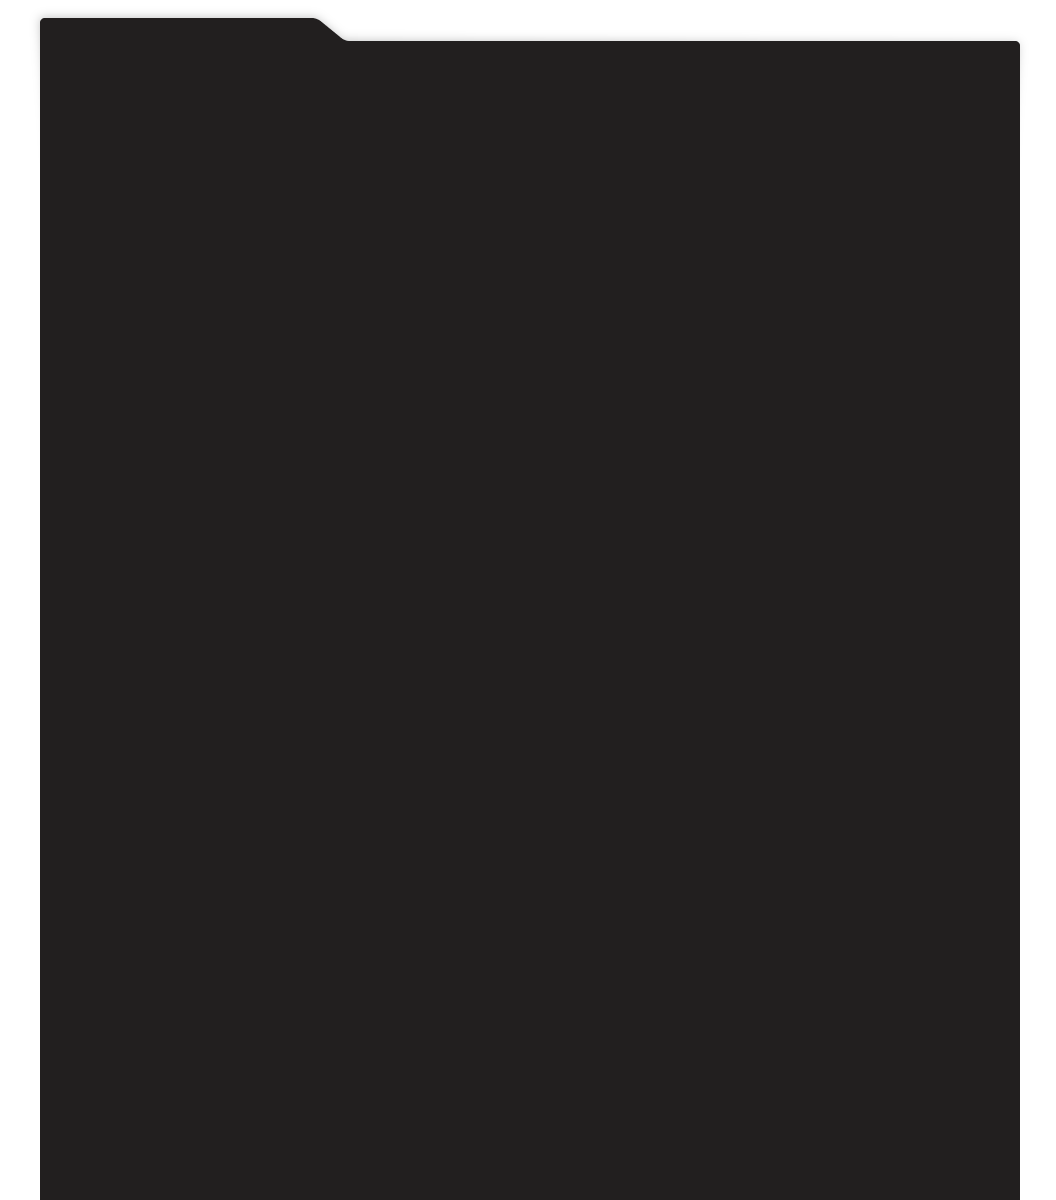
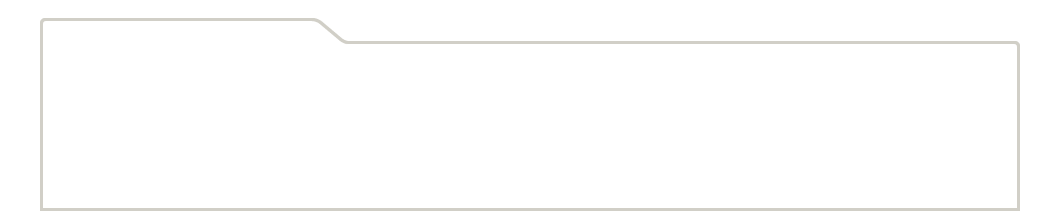
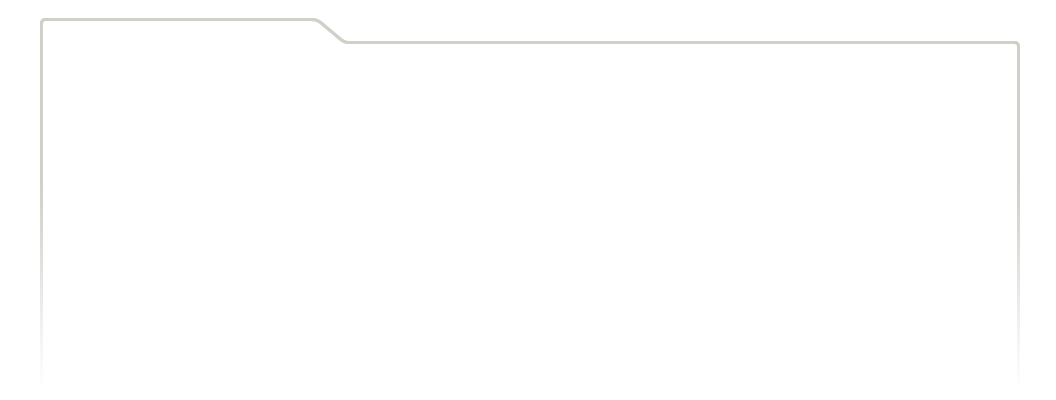
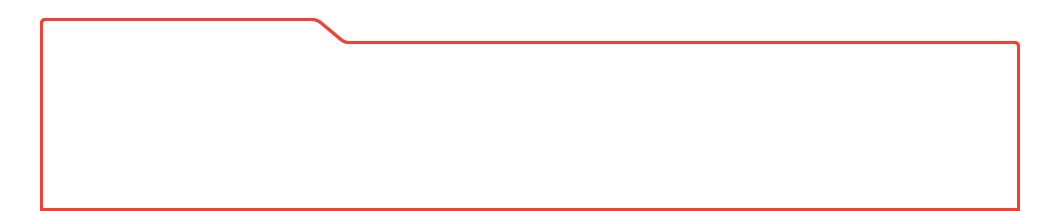
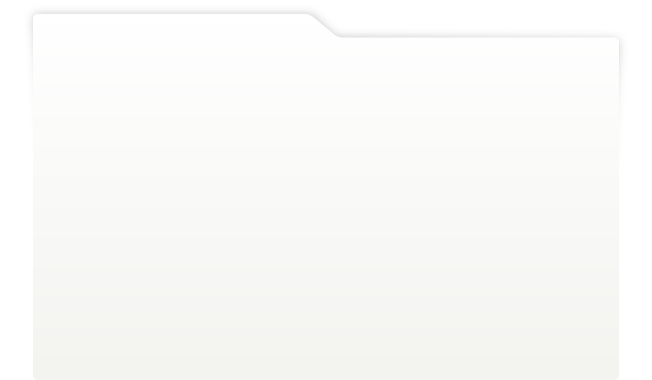
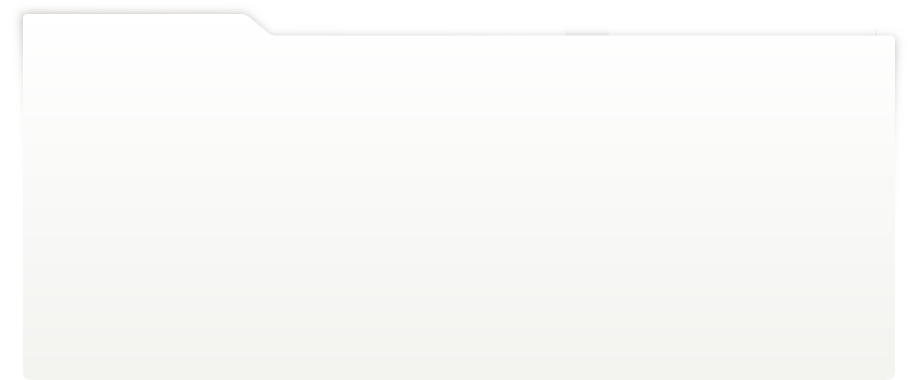
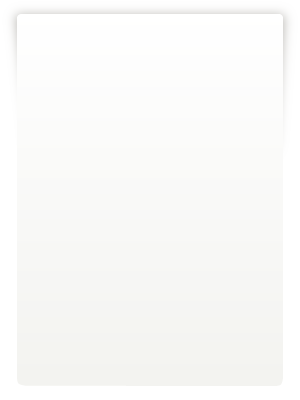
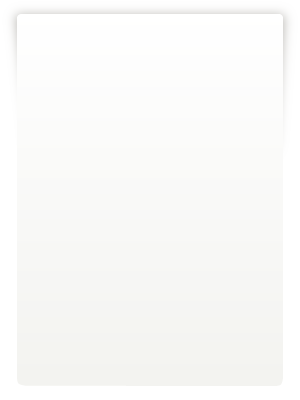
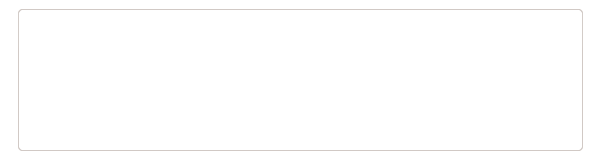
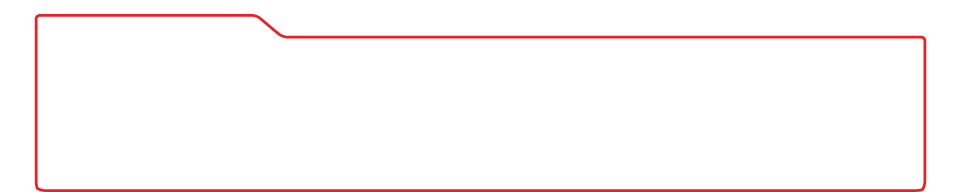
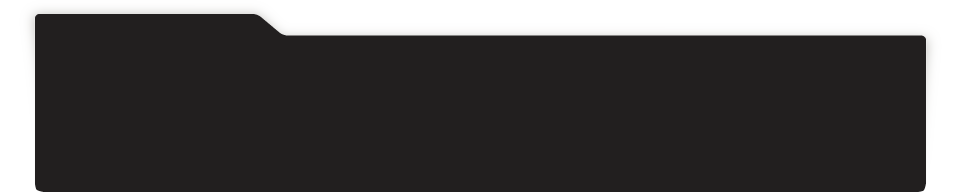
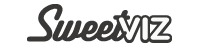
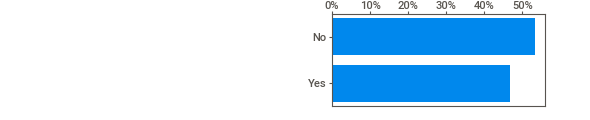
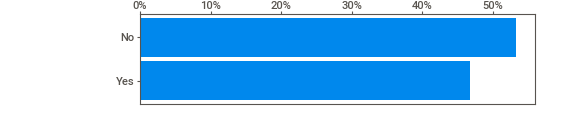
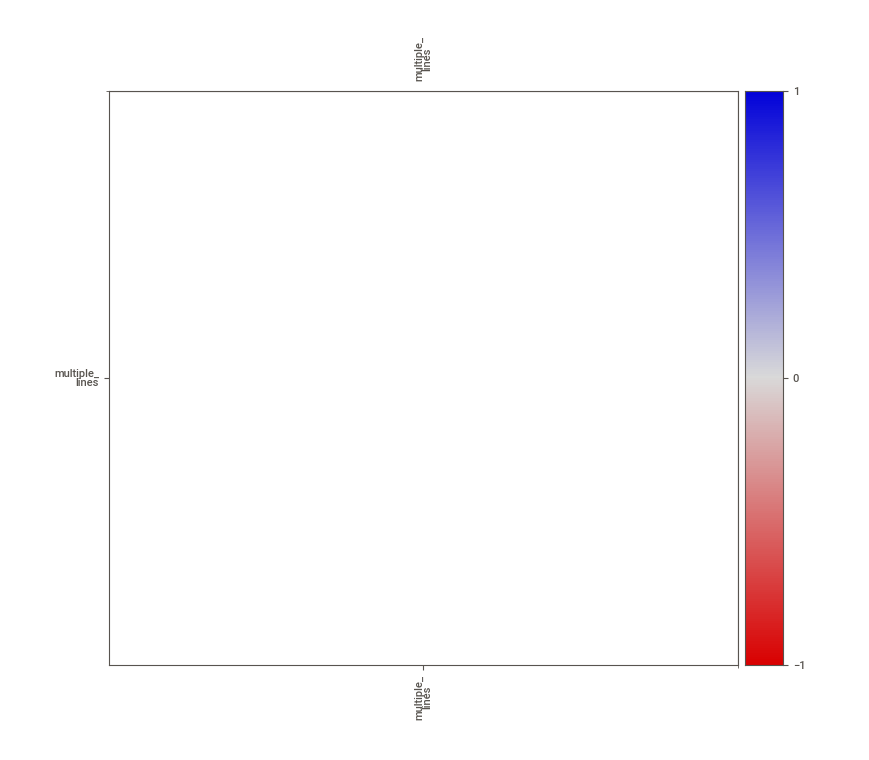
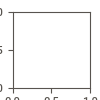

In [22]:
report_3 = sv.analyze([df_phone, "Данные телефонии"])
report_3.show_notebook()

**Промежуточные выводы:**
- привели названия колонок к змеиному регистру,
- уточнили типизацию колонок,
- имеем 6361 наблюдений, не все пользователи пользуются услугой связи,
- подключение телефона к нескольким линиям одновременно использует 47% пользователей,
- пропусков нет, типизация корректна.

## Объединение данных и исследовательский анализ

### Объединение и заполнение пропусков

Общую информацию о контракте и информацию о пользователях объединим срразу, здесь число наблдений совпадает.

In [17]:
df_final = df_contract.merge(df_personal, on = ['customer_id'])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(8)
memory usage: 715.3+ KB


Теперь присоединим к каждому контракту информацию об интернете и телефонии.

In [18]:
df_final = df_final.merge(df_internet, on = ['customer_id'], how = 'left')
df_final = df_final.merge(df_phone, on = ['customer_id'], how = 'left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [27]:
z = df_final[df_final['multiple_lines'].isna()]
z

customer_id begin_date   end_date            type paperless_billing  \
0     7590-VHVEG 2020-01-01        NaT  Month-to-month               Yes   
3     7795-CFOCW 2016-05-01        NaT        One year                No   
7     6713-OKOMC 2019-04-01        NaT  Month-to-month                No   
20    8779-QRDMV 2019-11-01        NaT  Month-to-month               Yes   
27    8665-UTDHZ 2019-11-01        NaT  Month-to-month                No   
...          ...        ...        ...             ...               ...   
7003  4501-VCPFK 2017-12-01 2019-04-01  Month-to-month                No   
7007  2274-XUATA 2014-02-01        NaT        Two year               Yes   
7029  2235-DWLJU 2019-08-01        NaT  Month-to-month               Yes   
7036  7750-EYXWZ 2019-02-01        NaT        One year                No   
7040  4801-JZAZL 2019-03-01        NaT  Month-to-month               Yes   

                 payment_method  monthly_charges  total_charges  gender  \
0              Electronic check            29.85          31.04  Female   
3     Bank transfer (automatic)            42.30        1960.60    Male   
7                  Mailed check            29.75         300.48  Female   
20             Electronic check            39.65         118.95    Male   
27             Electronic check            30.20          96.04    Male   
...                         ...              ...            ...     ...   
7003           Electronic check            35.75         572.00    Male   
7007  Bank transfer (automatic)            63.10        4861.22    Male   
7029           Electronic check            44.40         266.40  Female   
7036           Electronic check            60.65         727.80  Female   
7040           Electronic check            29.60         325.60  Female   

     senior_citizen partner dependents internet_service online_security  \
0                 0     Yes         No              DSL              No   
3                 0      No         No              DSL             Yes   
7                 0      No         No              DSL             Yes   
20                1      No         No              DSL              No   
27                0     Yes        Yes              DSL              No   
...             ...     ...        ...              ...             ...   
7003              0      No         No              DSL              No   
7007              1     Yes         No              DSL             Yes   
7029              1      No         No              DSL              No   
7036              0      No         No              DSL              No   
7040              0     Yes        Yes              DSL             Yes   

     online_backup device_protection tech_support streaming_t_v  \
0              Yes                No           No            No   
3               No               Yes          Yes            No   
7               No                No           No            No   
20              No               Yes           No            No   
27             Yes                No           No            No   
...            ...               ...          ...           ...   
7003            No               Yes          Yes            No   
7007           Yes               Yes          Yes           Yes   
7029            No                No           No           Yes   
7036           Yes               Yes          Yes           Yes   
7040            No                No           No            No   

     streaming_movies multiple_lines  
0                  No            NaN  
3                  No            NaN  
7                  No            NaN  
20                Yes            NaN  
27                 No            NaN  
...               ...            ...  
7003               No            NaN  
7007              Yes            NaN  
7029              Yes            NaN  
7036              Yes            NaN  
7040               No            NaN  

[682 rows x 20 c

Добавим целевой признак - расторжение договора. Не расторгнутыми будем считать те договора, где нет даты окончания.

In [25]:
# добавим целевой признак
df_final['termination'] = ~df_final.end_date.isna()
df_final['termination'] = df_final.termination.astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [26]:
#пропуски в колонке завершение договора заполним датой выгрузки 
df_final.end_date.fillna(LOAD_DATE, inplace=True)

In [27]:
#посмотрим почему у нас нет платежей у некотрых клиентов
df_final.query('total_charges.isna()')

customer_id begin_date    end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01  01-02-2020  Two year               Yes   
753   3115-CZMZD 2020-02-01  01-02-2020  Two year                No   
936   5709-LVOEQ 2020-02-01  01-02-2020  Two year                No   
1082  4367-NUYAO 2020-02-01  01-02-2020  Two year                No   
1340  1371-DWPAZ 2020-02-01  01-02-2020  Two year                No   
3331  7644-OMVMY 2020-02-01  01-02-2020  Two year                No   
3826  3213-VVOLG 2020-02-01  01-02-2020  Two year                No   
4380  2520-SGTTA 2020-02-01  01-02-2020  Two year                No   
5218  2923-ARZLG 2020-02-01  01-02-2020  One year               Yes   
6670  4075-WKNIU 2020-02-01  01-02-2020  Two year                No   
6754  2775-SEFEE 2020-02-01  01-02-2020  Two year               Yes   

                 payment_method  monthly_charges  total_charges  gender  \
488   Bank transfer (automatic)            52.55            NaN  Female   
753                Mailed check            20.25            NaN    Male   
936                Mailed check            80.85            NaN  Female   
1082               Mailed check            25.75            NaN    Male   
1340    Credit card (automatic)            56.05            NaN  Female   
3331               Mailed check            19.85            NaN    Male   
3826               Mailed check            25.35            NaN    Male   
4380               Mailed check            20.00            NaN  Female   
5218               Mailed check            19.70            NaN    Male   
6670               Mailed check            73.35            NaN  Female   
6754  Bank transfer (automatic)            61.90            NaN    Male   

     senior_citizen partner dependents internet_service online_security  \
488               0     Yes        Yes              DSL             Yes   
753               0      No        Yes              NaN             NaN   
936               0     Yes        Yes              DSL             Yes   
1082              0     Yes        Yes              NaN             NaN   
1340              0     Yes        Yes              DSL             Yes   
3331              0     Yes        Yes              NaN             NaN   
3826              0     Yes        Yes              NaN             NaN   
4380              0     Yes        Yes              NaN             NaN   
5218              0     Yes        Yes              NaN             NaN   
6670              0     Yes        Yes              DSL              No   
6754              0      No        Yes              DSL             Yes   

     online_backup device_protection tech_support streaming_t_v  \
488             No               Yes          Yes           Yes   
753            NaN               NaN          NaN           NaN   
936            Yes               Yes           No           Yes   
1082           NaN               NaN          NaN           NaN   
1340           Yes               Yes          Yes           Yes   
3331           NaN               NaN          NaN           NaN   
3826           NaN               NaN          NaN           NaN   
4380           NaN               NaN          NaN           NaN   
5218           NaN               NaN          NaN           NaN   
6670           Yes               Yes          Yes           Yes   
6754           Yes                No          Yes            No   

     streaming_movies multiple_lines  termination  
488                No            NaN            0  
753               NaN             No            0  
936               Yes             No            0  
1082              NaN            Yes            0  
1340               No            NaN            0  
3331              NaN             No            0  
3826              NaN            Yes            0  
4380              NaN             No            0  
5218              NaN             No            0  
6670               No    

Судя по всему это новые договора и оплата просто еще не прошла, мы не можем утверждать, что она точно пройдет и в каком объеме. Поэтому заполним пока эти места 0, пропусков менее 1% и вряд ли это существенно повлияет на исследование.

In [28]:
df_final.total_charges.fillna(0, inplace=True)

In [29]:
df_final[df_final.customer_id=='4472-LVYGI']

customer_id begin_date    end_date      type paperless_billing  \
488  4472-LVYGI 2020-02-01  01-02-2020  Two year               Yes   

                payment_method  monthly_charges  total_charges  gender  \
488  Bank transfer (automatic)            52.55            0.0  Female   

    senior_citizen partner dependents internet_service online_security  \
488              0     Yes        Yes              DSL             Yes   

    online_backup device_protection tech_support streaming_t_v  \
488            No               Yes          Yes           Yes   

    streaming_movies multiple_lines  termination  
488               No            NaN            0

In [30]:
# при отсутствии услуг телевидения/интернета поставим заглушку
df_final = df_final.fillna('no service')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Для работы с признаками в формате дат переведем их в дни - добавим признак время действия договора.

In [31]:
df_final['usage_time'] = (pd.to_datetime(df_final['end_date']) - pd.to_datetime(df_final['begin_date'])).dt.days
df_final.sample(5)

customer_id begin_date             end_date            type  \
268   6323-AYBRX 2015-02-01  2015-12-01 00:00:00        Two year   
2934  0208-BPQEJ 2019-02-01           01-02-2020  Month-to-month   
6776  6120-RJKLU 2014-12-01  2017-11-01 00:00:00        Two year   
4518  8808-ELEHO 2019-04-01           01-02-2020  Month-to-month   
447   0732-OCQOC 2015-10-01           01-02-2020        Two year   

     paperless_billing             payment_method  monthly_charges  \
268                 No               Mailed check            19.35   
2934                No  Bank transfer (automatic)            19.40   
6776               Yes    Credit card (automatic)            79.95   
4518               Yes           Electronic check            81.25   
447                Yes  Bank transfer (automatic)            25.05   

      total_charges  gender senior_citizen partner dependents  \
268          193.50    Male              0      No         No   
2934         256.08  Female              0     Yes        Yes   
6776        2798.25  Female              1     Yes         No   
4518         828.75    Male              1      No         No   
447         1302.60  Female              0     Yes        Yes   

     internet_service online_security online_backup device_protection  \
268        no service      no service    no service        no service   
2934       no service      no service    no service        no service   
6776              DSL             Yes            No               Yes   
4518      Fiber optic              No            No               Yes   
447        no service      no service    no service        no service   

     tech_support streaming_t_v streaming_movies multiple_lines  termination  \
268    no service    no service       no service             No            1   
2934   no service    no service       no service             No            0   
6776          Yes           Yes              Yes             No            1   
4518           No            No               No            Yes            0   
447    no service    no service       no service            Yes            0   

      usage_time  
268          303  
2934         335  
6776        1066  
4518         276  
447         1554

**Промежуточные выводы:**
- объединили датафреймы в один для дальнейшего исследования,
- заолнили пропуски соответствующими величинами(дата выгрузки для даты окончания контракта) или заглушкой если услуга не используется,
- создали целевой признак - расторжение договора - termination,
- перевели признаки из дат в длительность.
- получили итоговый датафрейм из 20 колонок и 7043 строк.

### Исследовательский анализ данных

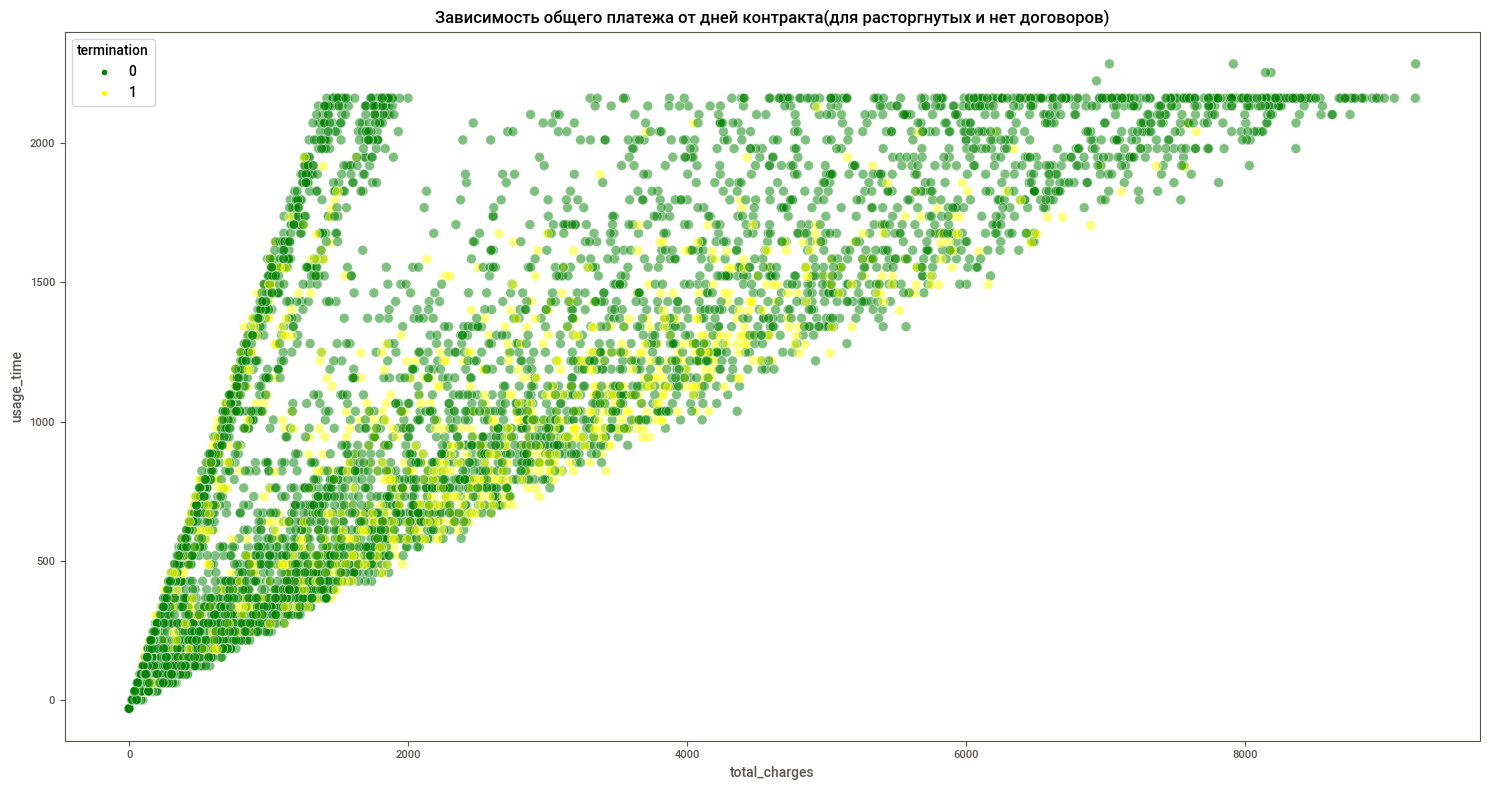

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8), dpi=100)
sns.scatterplot(data=df_final,
                x=df_final.total_charges,
                y=df_final.usage_time,
                ax=axes,
                palette=['green', 'yellow'],
                hue='termination', 
                s=50, 
                alpha=.5)
axes.set_title('Зависимость общего платежа от дней контракта(для расторгнутых и нет договоров)')
plt.tight_layout()
plt.show();

Ну линейной зависимости здесь явно нет, хотя другие вполне возможно что присутствуют.

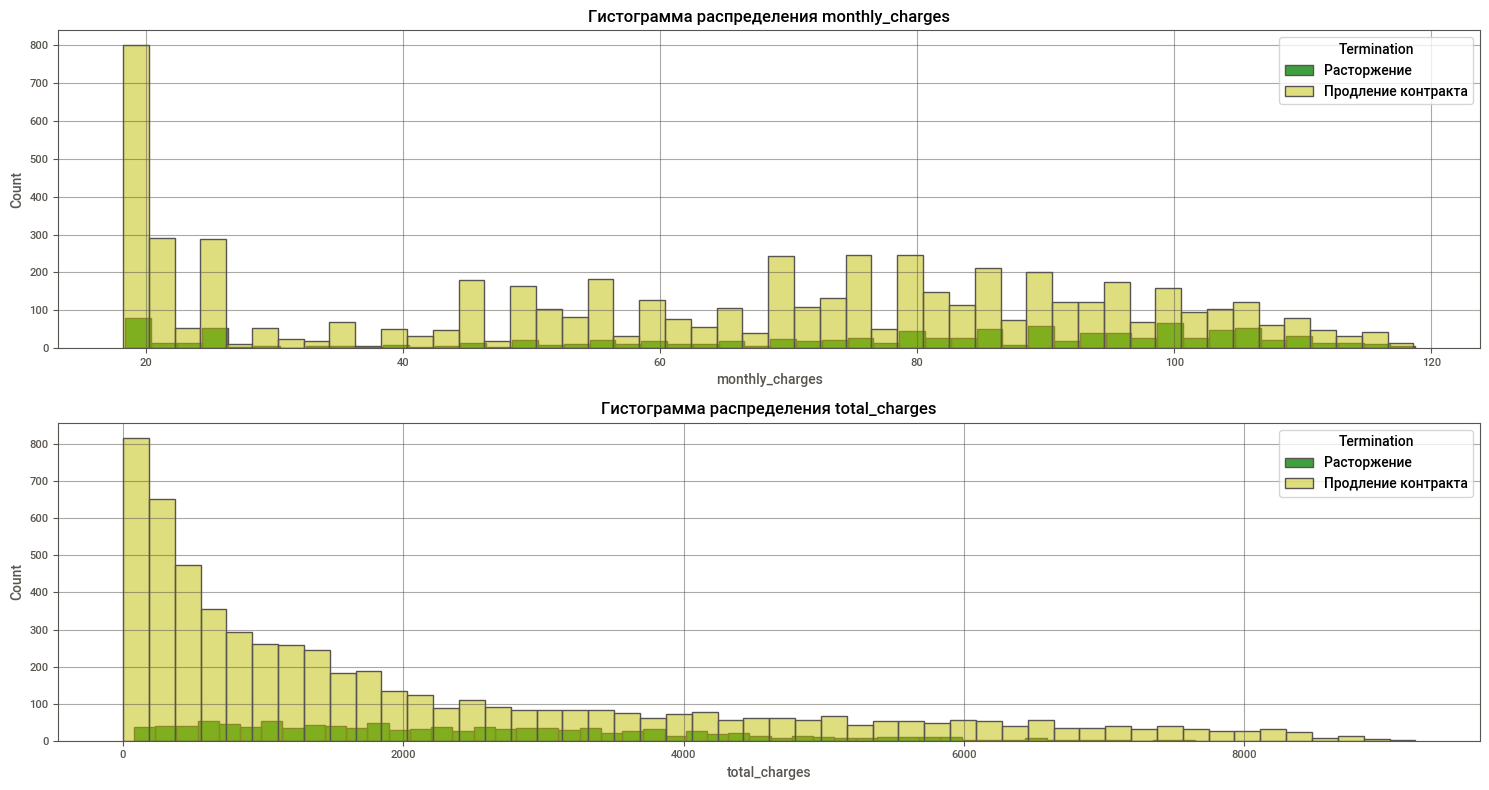

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,8), dpi=100)
sns.histplot(data=df_final.query('termination==1').monthly_charges, color='g',
             ax=axes[0], bins = 50, label='Расторжение')
sns.histplot(data=df_final.query('termination==0').monthly_charges, color='y',
             ax=axes[0], bins = 50, alpha=0.5, label='Продление контракта')
sns.histplot(data=df_final.query('termination==1').total_charges,
             color='g',ax=axes[1], bins = 50, label='Расторжение')
sns.histplot(data=df_final.query('termination==0').total_charges, color='y',ax=axes[1],
             bins = 50, alpha=0.5, label='Продление контракта')
axes[0].set_title('Гистограмма распределения monthly_charges')
axes[1].set_title('Гистограмма распределения total_charges')
axes[0].legend(title='Termination', loc='upper right')
axes[1].legend(title='Termination', loc='upper right')  # Размещаем легенду
axes[0].grid(True, alpha=0.5)
axes[1].grid(True, alpha=0.5)
plt.tight_layout()
plt.show();

В целом клиенты с меньшей суммой месяцных платежей реже расторгают договор, частора расторжение растет с увеличением цены.
А рассматривая годовые платежи можно сказать тоже, хоть и закономерность не слишком яркая. Но в целом логичная, чем выголнеее договор, тем реже расторгается.

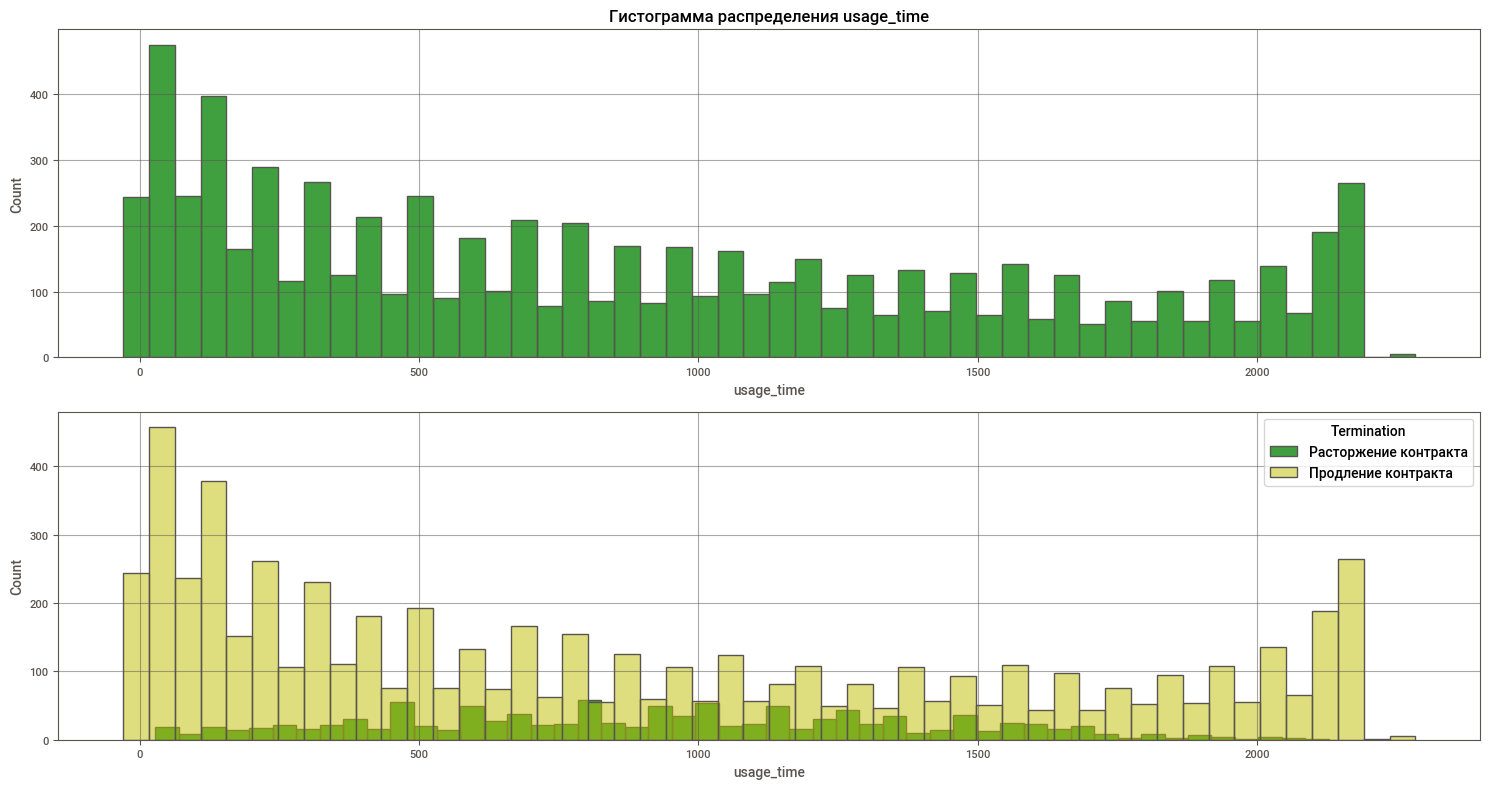

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,8), dpi=100)
sns.histplot(data=df_final.usage_time, color='g',ax=axes[0], bins = 50)
sns.histplot(data=df_final.query('termination==1').usage_time, color='g',
             ax=axes[1], bins = 50, label='Расторжение контракта')
sns.histplot(data=df_final.query('termination==0').usage_time,
             color='y',ax=axes[1], bins = 50, alpha=0.5, label='Продление контракта')
axes[0].set_title('Гистограмма распределения usage_time')
axes[1].legend(title='Termination', loc='upper right')
axes[1].grid(True, alpha=0.5)
axes[0].grid(True, alpha=0.5)
plt.tight_layout()
plt.show();

Чаще расторгаются договора со средним сроком,клиенты кто давно с компанией видимо ей довольны.

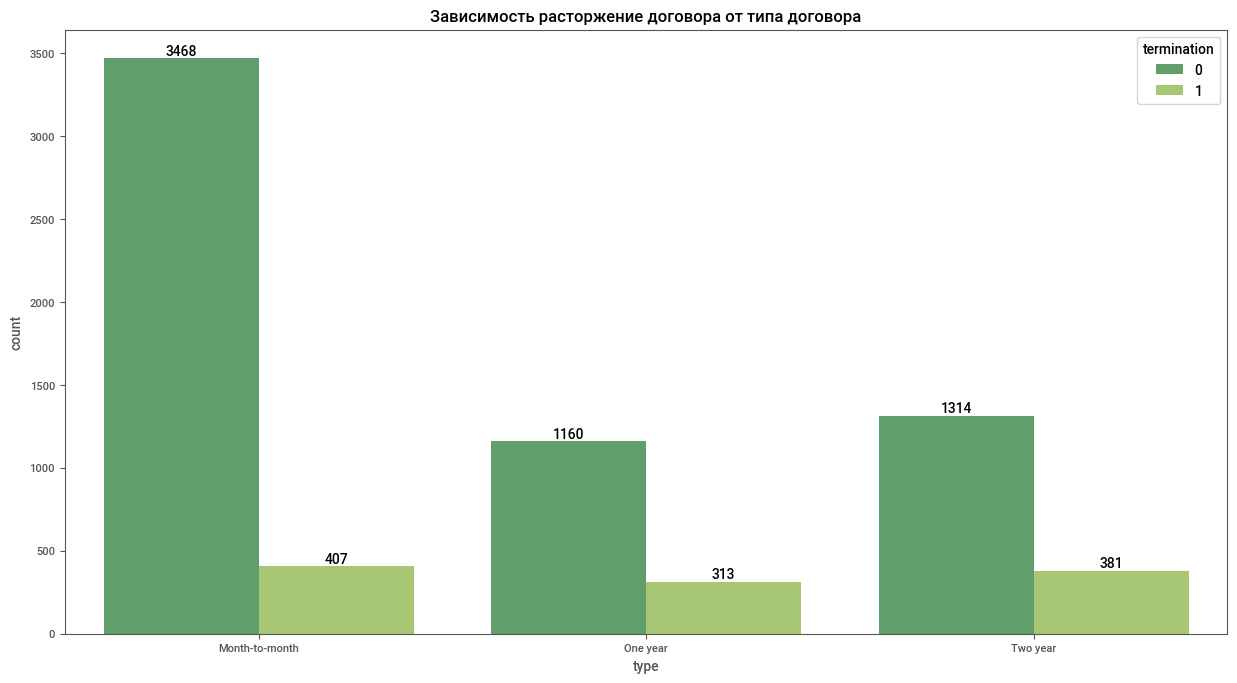

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(15,8))
axes.set_title('Зависимость расторжение договора от типа договора')
sns.countplot(x='type', data=df_final, hue='termination', ax=axes, palette='summer')
# Рассчитываем проценты для каждого столбца
for i in axes.containers:
    axes.bar_label(i,)

Чаще всего расторгаются договора с оплатой на 2 года, реже всего с помесячной оплатой.

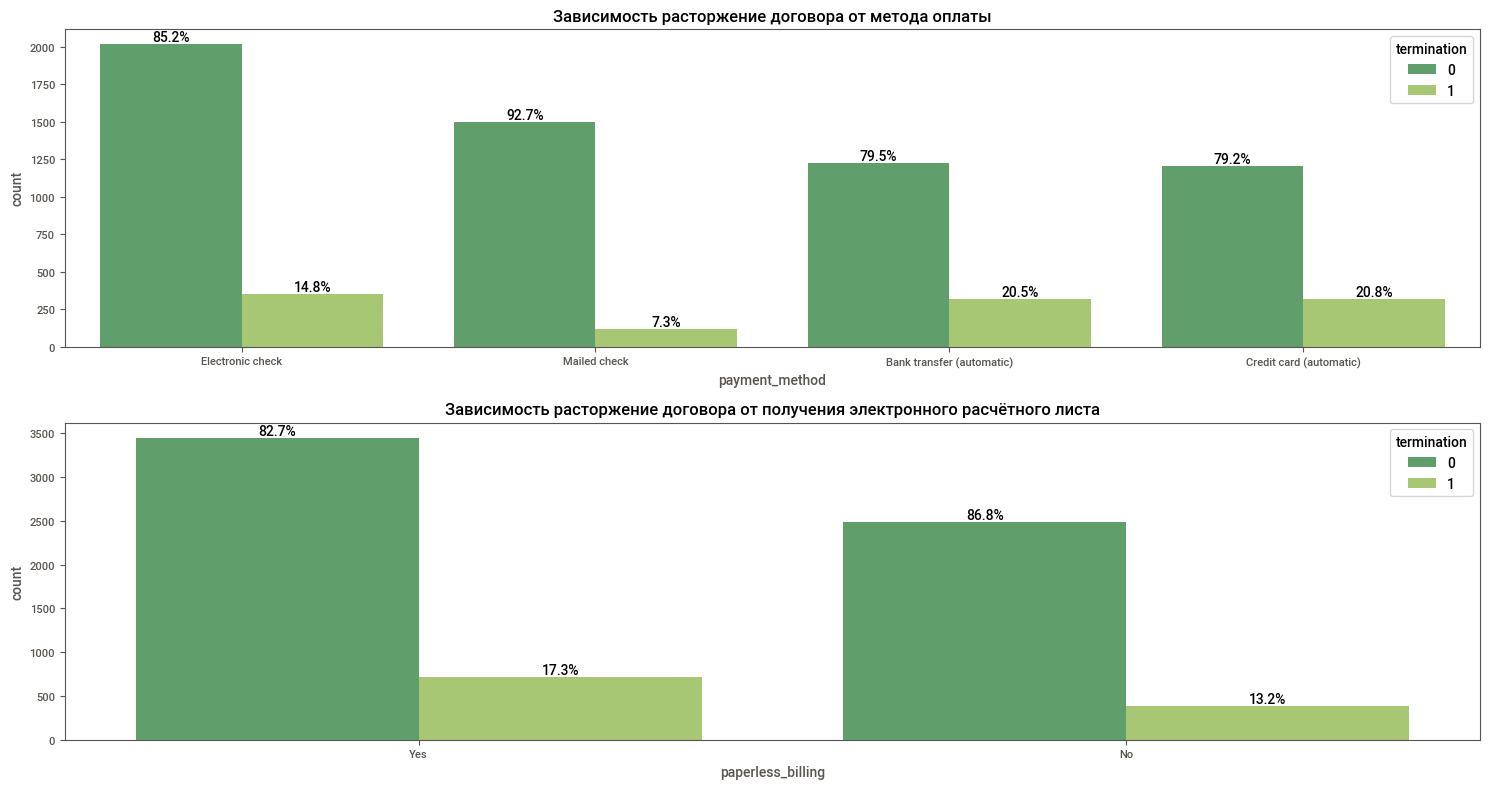

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=100, figsize=(15,8))
axes[0].set_title('Зависимость расторжение договора от метода оплаты')
sns.countplot(x='payment_method', data=df_final, hue='termination', ax=axes[0], palette='summer')
# Рассчитываем проценты для каждого столбца
total_counts_0 = df_final['payment_method'].value_counts().sort_values(ascending=False)
for container in axes[0].containers:
    # Получаем высоту каждого столбца
    heights = [bar.get_height() for bar in container] 
    # Рассчитываем проценты
    percentages = [f'{(height / total_counts_0[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]
    
    # Добавляем подписи
    axes[0].bar_label(container, labels=percentages, label_type='edge')
axes[1].set_title('Зависимость расторжение договора от получения электронного расчётного листа')
sns.countplot(x='paperless_billing', data=df_final, hue='termination', ax=axes[1], palette='summer')
total_counts_1 = df_final['paperless_billing'].value_counts().sort_values(ascending=False)
for container in axes[1].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_1[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]
    
    axes[1].bar_label(container, labels=percentages, label_type='edge')

plt.tight_layout()

plt.show();

Чаще расторгают договора клиенты, которые пользуются автоматическими видами списаний средств (около 20% для каждого вида),
реже всего консервативные с бумажными чеками.
Зависимость от получения бумажных чеков нельзя назвать существенной,но те кто не получают лишних бумаг растограгаютя реже.

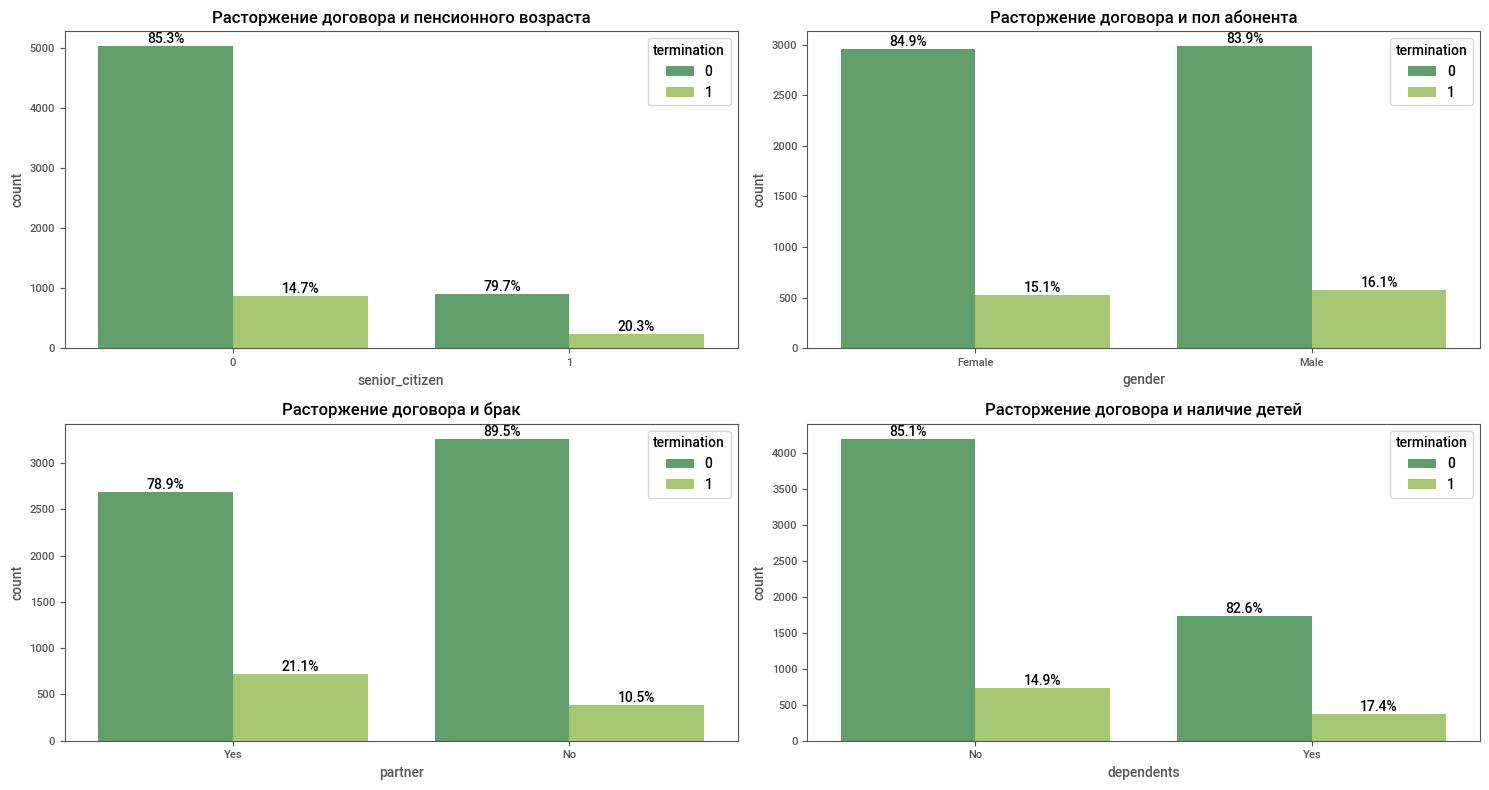

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(15,8))
axes[0,0].set_title('Расторжение договора и пенсионного возраста')
sns.countplot(x='senior_citizen', data=df_final, hue='termination', ax=axes[0,0], palette='summer')
total_counts_0 = df_final['senior_citizen'].value_counts().sort_values(ascending=False)
for container in axes[0,0].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_0[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[0,0].bar_label(container, labels=percentages, label_type='edge')
axes[0,1].set_title('Расторжение договора и пол абонента')
sns.countplot(x='gender', data=df_final, hue='termination', ax=axes[0,1], palette='summer')
total_counts_1 = df_final['gender'].value_counts().sort_values()
for container in axes[0,1].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_1[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[0,1].bar_label(container, labels=percentages, label_type='edge')
axes[1,0].set_title('Расторжение договора и брак')
sns.countplot(x='partner', data=df_final, hue='termination', ax=axes[1,0], palette='summer')
total_counts_2 = df_final['partner'].value_counts().sort_values()
for container in axes[1,0].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_2[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[1, 0].bar_label(container, labels=percentages, label_type='edge')
axes[1,1].set_title('Расторжение договора и наличие детей')
sns.countplot(x='dependents', data=df_final, hue='termination', ax=axes[1,1], palette='summer')
total_counts_3 = df_final['dependents'].value_counts().sort_values(ascending=False)
for container in axes[1,1].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_3[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[1, 1].bar_label(container, labels=percentages, label_type='edge')
plt.tight_layout()
plt.show();

Люди имеющие статус пенсионера или состоящие в партнерских отношениях чаще растограюг логовора, пол и наличие детей не слишком влияют на расторжения.

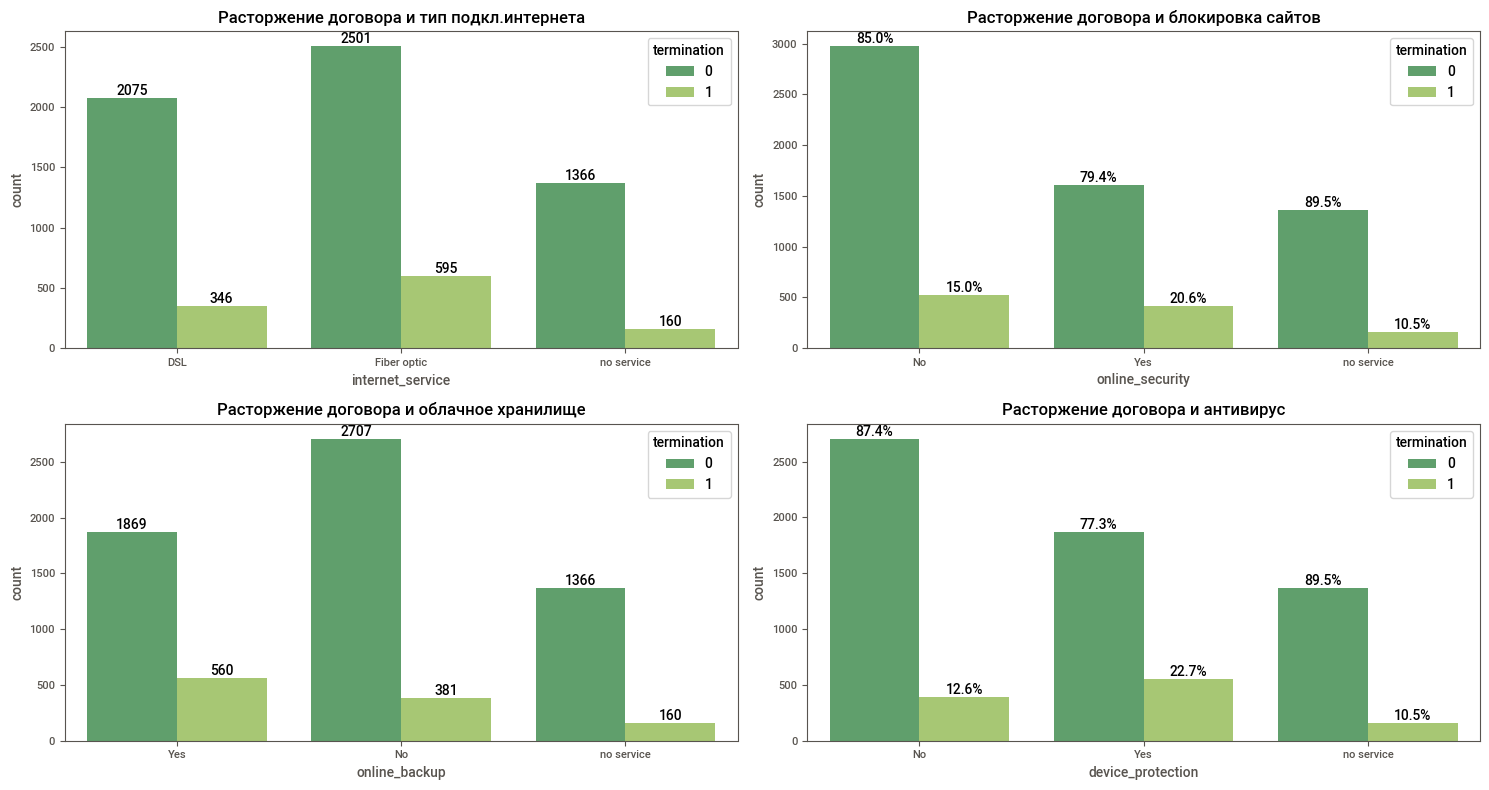

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(15,8))
axes[0,0].set_title('Расторжение договора и тип подкл.интернета')
sns.countplot(x='internet_service', data=df_final, hue='termination', ax=axes[0,0], palette='summer')
for i in axes[0,0].containers:
    axes[0,0].bar_label(i,)

axes[0,1].set_title('Расторжение договора и блокировка сайтов')
sns.countplot(x='online_security', data=df_final, hue='termination', ax=axes[0,1], palette='summer')
total_counts_1 = df_final['online_security'].value_counts().sort_values(ascending=False)
for container in axes[0,1].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_1[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[0,1].bar_label(container, labels=percentages, label_type='edge')
axes[1,0].set_title('Расторжение договора и облачное хранилище')
sns.countplot(x='online_backup', data=df_final, hue='termination', ax=axes[1,0], palette='summer')
total_counts_2 = df_final['online_backup'].value_counts().sort_values()
for i in axes[1,0].containers:
    axes[1,0].bar_label(i,)
axes[1,1].set_title('Расторжение договора и антивирус')
sns.countplot(x='device_protection', data=df_final, hue='termination', ax=axes[1,1], palette='summer')
total_counts_3 = df_final['device_protection'].value_counts().sort_values(ascending=False)
for container in axes[1,1].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_3[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[1, 1].bar_label(container, labels=percentages, label_type='edge')
plt.tight_layout()
plt.show();

Чаще расторгаются договора интернет провайдера с подключением по оптоволокну и использованием блокировки опасных сайтов.
При этом пользование антивирусом и облаком скорее ведет к расторжение договора. Услуги не так хороши?

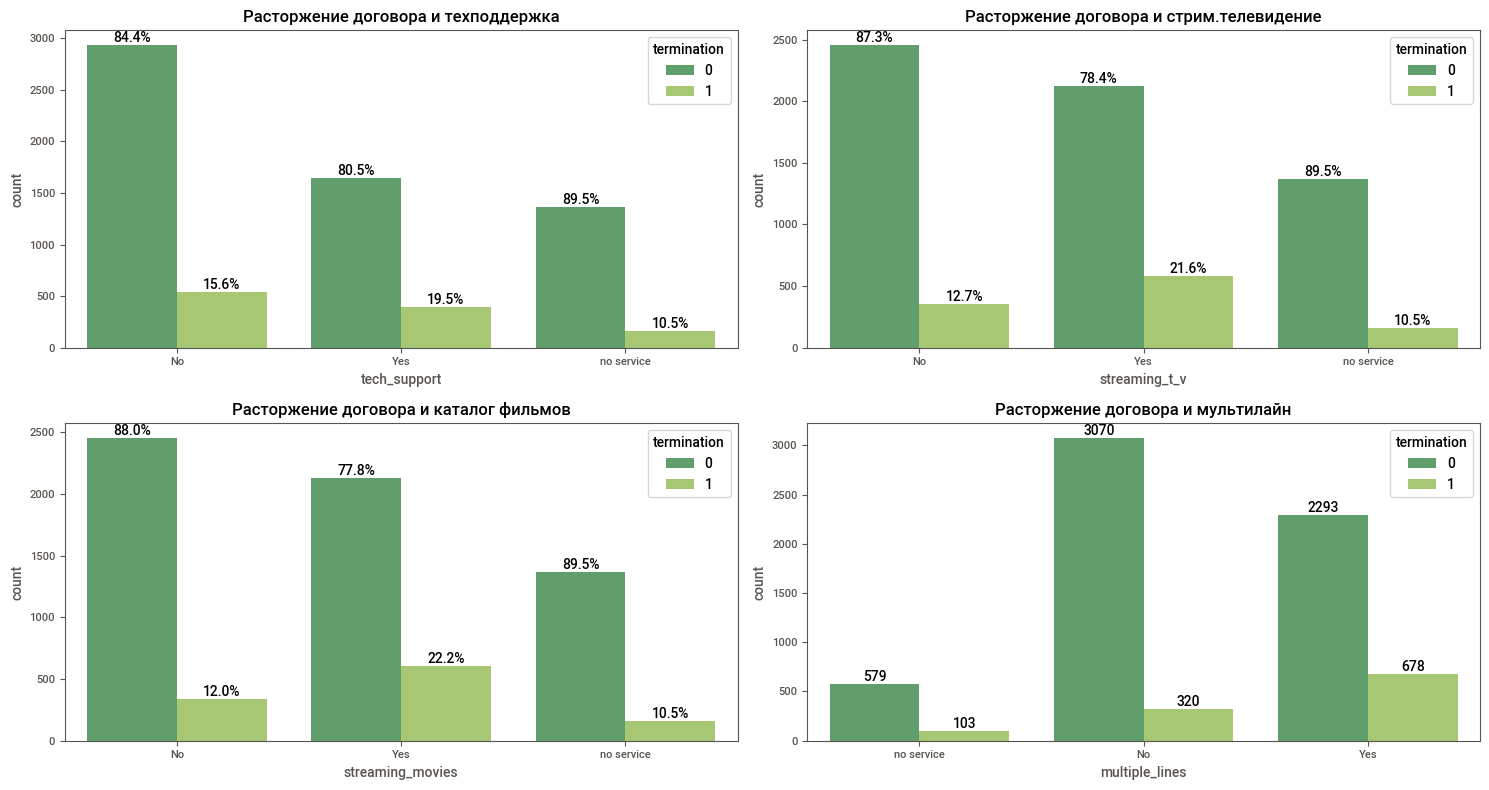

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(15,8))
axes[0,0].set_title('Расторжение договора и техподдержка')
sns.countplot(x='tech_support', data=df_final, hue='termination', ax=axes[0,0], palette='summer')
total_counts_0 = df_final['tech_support'].value_counts().sort_values(ascending=False)
for container in axes[0,0].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_0[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[0,0].bar_label(container, labels=percentages, label_type='edge')
axes[0,1].set_title('Расторжение договора и стрим.телевидение')
sns.countplot(x='streaming_t_v', data=df_final, hue='termination', ax=axes[0,1], palette='summer')
total_counts_1 = df_final['streaming_t_v'].value_counts().sort_values(ascending=False)
for container in axes[0,1].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_1[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[0,1].bar_label(container, labels=percentages, label_type='edge')
axes[1,0].set_title('Расторжение договора и каталог фильмов')
sns.countplot(x='streaming_movies', data=df_final, hue='termination', ax=axes[1,0], palette='summer')
total_counts_2 = df_final['streaming_movies'].value_counts().sort_values(ascending=False)
for container in axes[1,0].containers:
    heights = [bar.get_height() for bar in container] 
    percentages = [f'{(height / total_counts_2[i]) * 100:.1f}%' 
                   for i, height in enumerate(heights)]

    axes[1, 0].bar_label(container, labels=percentages, label_type='edge')
axes[1,1].set_title('Расторжение договора и мультилайн')
sns.countplot(x='multiple_lines', data=df_final, hue='termination', ax=axes[1,1], palette='summer')
for i in axes[1,1].containers:
    axes[1,1].bar_label(i,)
plt.tight_layout()
plt.show();

Картина с телевидением похожа - чем больше сервисов, тем чаще расторжение - стримонговое телефвтидение и фильмотека не удерживают пользователей.

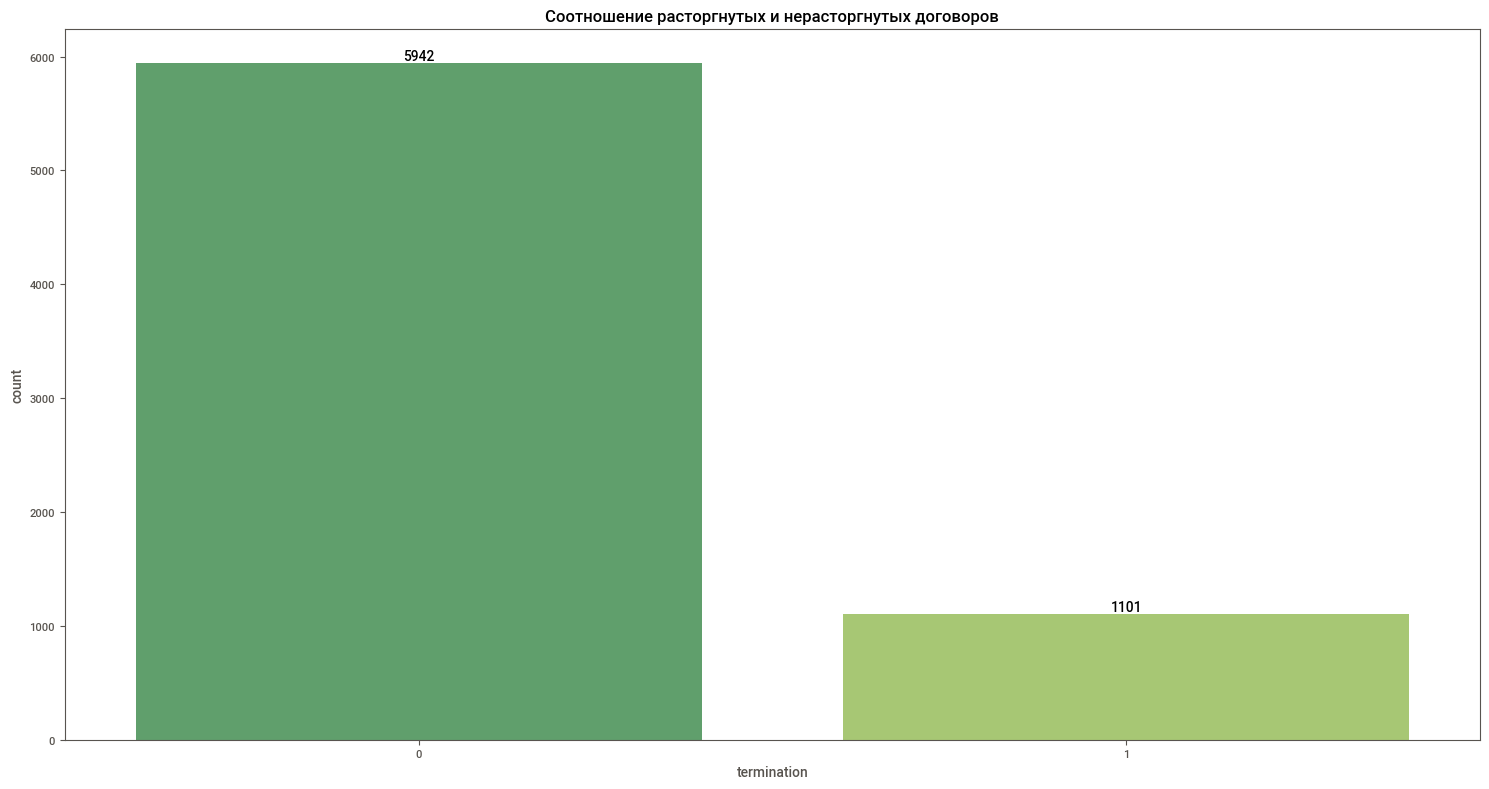

In [40]:
fig, axes = plt.subplots(dpi=100, figsize=(15,8))
axes.set_title('Соотношение расторгнутых и нерасторгнутых договоров')
sns.countplot(x='termination', data=df_final, ax=axes, palette='summer')
for i in axes.containers:
    axes.bar_label(i,)
plt.tight_layout()
plt.show();

Явный дисбаланс классов, что нормально. В шесть раз чаще договор пролонгируется, иначе компания бы обанкротилась.

**Промежуточные выводы:**
- чаще расторгают договора клиенты с оплатой раз в 2 года, средним чеком, пенсионного возраста или состояние в партнерских оношениях, кроме пользование дополнительными услугами скорее ведет к расторжению договора,
- влияние большинства факторов по отдельности нельзя назвать слишком существенным,скорее всего здесь скорее работают сочетания признаков чем 1-2 основных,
- присутствет дисбаланс классов(расторгают договор значительно реже)

### Корреляционный анализ

In [41]:
df_final.drop(columns=['begin_date', 'end_date', 'customer_id'], inplace=True)

In [42]:
interval_cols = ['monthly_charges','total_charges', 'usage_time']

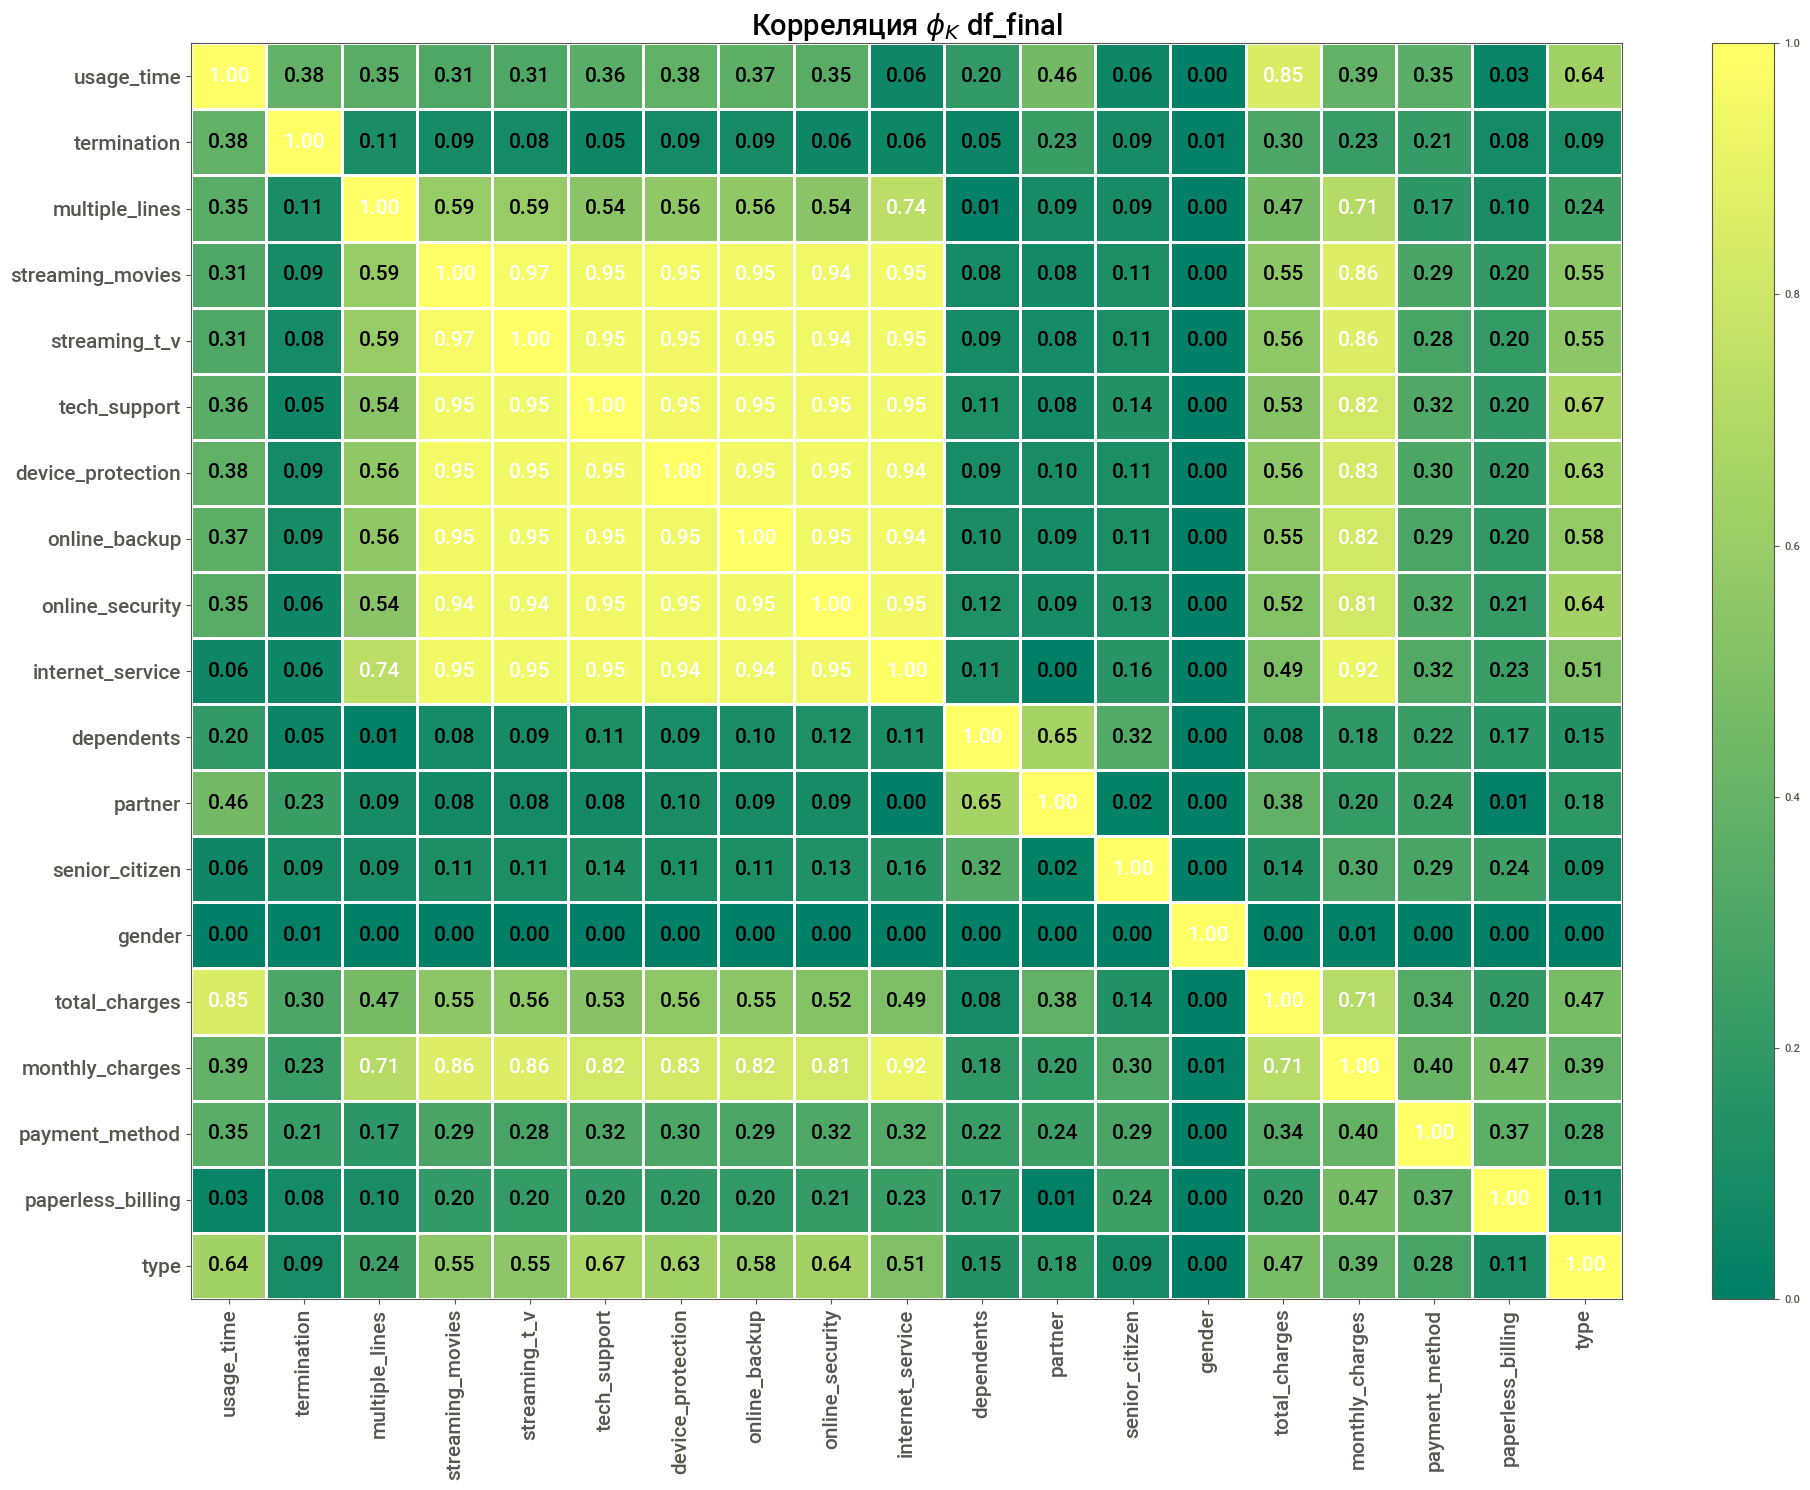

In [43]:
phik_overview = (
    df_final
    .phik_matrix(verbose=False, interval_cols=interval_cols))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_final',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Промежуточные выводы:**
- явного влияния на целевой признак одного из входных признаков не выявлено,
- признаки касаюющиеся услучи предоставления интернета показывают мультиколлинеарность, что логично, но удалять их не вижу смысла, надо посмотреть как отработает модель,
- так же сильно кореллируют иннтернет сервис и месячная оплата, но тоже оставим оба, платежи показывают корреляцию со всеми параметрами интернета, но это может быть особенностями тарифной сетки,
- попробуем поработать со всеми признаками.

## Моделирование

Рассмотрим классы моделей:
- решающее дерево или случайный лес(RandomForestClassifier),
- бустинги (CatBoostClassifier),
- нейронные сети (MLPClassifier).
Оценим её качество метрикой ROC-AUC(>0,85).
Выберем лучшую модель по значению метрики на кросс-валидации.

### Разделение на выборки и пайплайн

In [44]:
#DF для сравнений
df_scoring=pd.DataFrame(columns=['model_name', 'roc-auc_train'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('termination', axis = 1),
                                                    df_final['termination'],
                                                    test_size=TEST_SIZE,
                                                    stratify=df_final['termination'],
                                                    random_state=RANDOM_STATE)

#проверка размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5282, 18) (1761, 18) (5282,) (1761,)


In [46]:
cat_col = ['type', 'paperless_billing', 'gender', 'payment_method', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies', 'multiple_lines']

In [47]:
num_col = ['monthly_charges', 'total_charges', 'usage_time']

### RandomForestClassifier

In [48]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ord_pipe_rf = Pipeline(
    [('simpleImputer_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', 
            OrdinalEncoder( 
             handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor_rf = ColumnTransformer(
    [('ord', ord_pipe_rf, cat_col),
     ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough', force_int_remainder_cols=False
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_fin_rf = Pipeline([
    ('preprocessor', data_preprocessor_rf),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [49]:
param_rfc= [
    {
    'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
    'models__n_estimators' : [128, 150],
    'models__max_depth': [7, 8, 9],
    'models__max_features': [ 12, 15],
    'preprocessor__num': [StandardScaler()],

    },  
    
   
]
search_rfc = GridSearchCV(pipe_fin_rf, param_rfc, cv=5, scoring='roc_auc', verbose=1)

In [50]:
%%time
search_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 1min 10s, sys: 62.9 ms, total: 1min 10s
Wall time: 1min 10s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan))]),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'gender',
                                                                          'p...
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'usage_time'])])),
                                       ('models',
                                        RandomForestClassifier(random_state=170325))]),
             param_grid=[{'models': [RandomForestClassifier(class_weight='balanced',
                                                            random_state=170325)],
                          'models__max_depth': [7, 8, 9],
                          'models__max_features': [12, 15],
                          'models__n_estimators': [128, 150],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='roc_auc', verbose=1)

In [51]:
best_rfc=search_rfc.best_estimator_
cross_params(search_rfc)

Парамерты лучшей модели {'models': RandomForestClassifier(class_weight='balanced', random_state=170325), 'models__max_depth': 9, 'models__max_features': 15, 'models__n_estimators': 150, 'preprocessor__num': StandardScaler()}
ROC-AUC с лучшими гиперпараметрами на кросс-валидации : 0.8244043497310786


rank_test_score  mean_test_score  \
0                1         0.824404   
1                2         0.823785   
2                3         0.823777   
3                4         0.823745   
4                5         0.823402   

                                                                                                                                                                                                     params  \
0  {'models': RandomForestClassifier(class_weight='balanced', random_state=170325), 'models__max_depth': 9, 'models__max_features': 15, 'models__n_estimators': 150, 'preprocessor__num': StandardScaler()}   
1  {'models': RandomForestClassifier(class_weight='balanced', random_state=170325), 'models__max_depth': 8, 'models__max_features': 12, 'models__n_estimators': 150, 'preprocessor__num': StandardScaler()}   
2  {'models': RandomForestClassifier(class_weight='balanced', random_state=170325), 'models__max_depth': 8, 'models__max_features': 12, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}   
3  {'models': RandomForestClassifier(class_weight='balanced', random_state=170325), 'models__max_depth': 9, 'models__max_features': 15, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}   
4  {'models': RandomForestClassifier(class_weight='balanced', random_state=170325), 'models__max_depth': 8, 'models__max_features': 15, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}   

   mean_fit_time  
0       1.350292  
1       1.104648  
2       0.941942  
3       1.171030  
4       1.115938

In [52]:
df_scoring.loc[len(df_scoring.index)]=('RandomForestClassifier', search_rfc.best_score_)

### CatBoostClassifier

In [53]:
pipe_cat = CatBoostClassifier(loss_function ='Logloss',
                             logging_level='Silent',
                             auto_class_weights='Balanced',
                             eval_metric = 'AUC',
                             cat_features=cat_col,
                             random_state=RANDOM_STATE)
param_cat = [
    {
        'iterations': [1500, 1700],
        'learning_rate': [0.3, 0.4],
        'depth': [2, 3],
    },  
]
search_cat = GridSearchCV(pipe_cat, param_cat, cv=3, scoring='roc_auc', verbose=1)# поиск оптимальных параметров

In [54]:
%%time
search_cat.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 2min 36s, sys: 5.93 s, total: 2min 42s
Wall time: 3min 10s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fbd8a326be0>,
             param_grid=[{'depth': [2, 3], 'iterations': [1500, 1700],
                          'learning_rate': [0.3, 0.4]}],
             scoring='roc_auc', verbose=1)

In [55]:
cross_params(search_cat)

Парамерты лучшей модели {'depth': 2, 'iterations': 1700, 'learning_rate': 0.4}
ROC-AUC с лучшими гиперпараметрами на кросс-валидации : 0.945804127689622


rank_test_score  mean_test_score  \
0                1         0.945804   
1                2         0.945214   
2                3         0.943579   
3                4         0.941646   
4                5         0.934329   

                                                   params  mean_fit_time  
0  {'depth': 2, 'iterations': 1700, 'learning_rate': 0.4}       6.753019  
1  {'depth': 2, 'iterations': 1500, 'learning_rate': 0.4}       6.196123  
2  {'depth': 2, 'iterations': 1700, 'learning_rate': 0.3}       7.037491  
3  {'depth': 2, 'iterations': 1500, 'learning_rate': 0.3}       6.038615  
4  {'depth': 3, 'iterations': 1700, 'learning_rate': 0.4}       9.062475

In [56]:
best_cat=search_cat.best_estimator_

In [57]:
df_scoring.loc[len(df_scoring.index)]=('CatBoostClassifier', search_cat.best_score_)

### MLPClassifier

In [58]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_col),  
     ('num', StandardScaler(), num_col)  
    ], 
    remainder='passthrough'  
)


pipe_net = Pipeline([
    ('preprocessor', data_preprocessor),  
    ('models', MLPClassifier(max_iter=1500, early_stopping=True))  
])

In [59]:
param_net = {
    'models__hidden_layer_sizes': CategoricalDistribution([
        (32,), 
        (56,),
        (32, 16),
        (56, 24),  
        (64, 32),  
        (64, 32, 16),
        (80, 20, 10),
    ]),  
    'models__activation': CategoricalDistribution(['relu', 'tanh']),  
    'models__solver': CategoricalDistribution(['adam', 'sgd']), 
    'models__alpha': FloatDistribution(1e-3, 1e-1, log=True),  
    'models__learning_rate_init': FloatDistribution(1e-3, 1e-1, log=True), 
}

study = optuna.create_study(direction='maximize', sampler=RandomSampler())

# Поиск лучших параметров
search_net = OptunaSearchCV(
    pipe_net,  
    param_net,  
    scoring='roc_auc',  
    n_trials=10, #немного,но практика показала что больших результатов тут добиться тяжеловато и большим количеством итераций
    verbose=1,
    study=study,
)

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (32,) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (56,) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (32, 16) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 

In [60]:
%%time
# Обучение модели
search_net.fit(X_train, y_train)

[I 2025-03-26 12:28:01,672] Trial 0 finished with value: 0.7259194028117965 and parameters: {'models__hidden_layer_sizes': (32,), 'models__activation': 'relu', 'models__solver': 'sgd', 'models__alpha': 0.056500181799457386, 'models__learning_rate_init': 0.015487697108667856}. Best is trial 0 with value: 0.7259194028117965.
[I 2025-03-26 12:28:50,871] Trial 1 finished with value: 0.7935713817875758 and parameters: {'models__hidden_layer_sizes': (56, 24), 'models__activation': 'tanh', 'models__solver': 'sgd', 'models__alpha': 0.020511906341688136, 'models__learning_rate_init': 0.04783665702384299}. Best is trial 1 with value: 0.7935713817875758.
[I 2025-03-26 12:29:05,276] Trial 2 finished with value: 0.5022184980490441 and parameters: {'models__hidden_layer_sizes': (32, 16), 'models__activation': 'tanh', 'models__solver': 'sgd', 'models__alpha': 0.003912205918234343, 'models__learning_rate_init': 0.0012914451712536185}. Best is trial 1 with value: 0.7935713817875758.
[I 2025-03-26 12:29

CPU times: user 2min 24s, sys: 2min 3s, total: 4min 27s
Wall time: 4min 29s


OptunaSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['type',
                                                                            'paperless_billing',
                                                                            'gender',
                                                                            'payment_method',
                                                                            'senior_citizen'...
                                    'models__hidden_layer_sizes': CategoricalDistribution(choices=((32,), (56,), (32, 16), (56, 24), (64, 32), (64, 32, 16), (80, 20, 10))),
                                    'models__learning_rate_init': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'models__solver': CategoricalDistribution(choices=('adam', 'sgd'))},
               scoring='roc_auc',
               study=<optuna.study.study.Study object at 0x7fbd8c0fbdf0>,
               verbose=1)

In [61]:
search_net.cv_results_
df_cg=pd.DataFrame(search_net.cv_results_)[
['mean_test_score', 'mean_fit_time']
    ].sort_values('mean_test_score', ascending=False)[:5].reset_index(drop=True)
print("Парамерты лучшей модели",search_net.best_params_)
print("ROC-AUC с лучшими гиперпараметрами на кросс-валидации :", search_net.best_score_)
display(df_cg)

Парамерты лучшей модели {'models__hidden_layer_sizes': (56,), 'models__activation': 'relu', 'models__solver': 'adam', 'models__alpha': 0.057718693441195346, 'models__learning_rate_init': 0.05357724582395624}
ROC-AUC с лучшими гиперпараметрами на кросс-валидации : 0.8029936986876637


mean_test_score  mean_fit_time
0         0.802994       5.694915
1         0.801670       6.570692
2         0.793571       9.611442
3         0.732729      10.176954
4         0.725919       3.356882

In [62]:
df_scoring.loc[len(df_scoring.index)]=('MLPClassifier', search_net.best_score_)

## Тестирование лучшей модели

In [63]:
df_scoring

model_name  roc-auc_train
0  RandomForestClassifier       0.824404
1      CatBoostClassifier       0.945804
2           MLPClassifier       0.802994

Что ж с явным отрывом выигрывает CatBoostClassifier{'depth': 2, 'iterations': 1700, 'learning_rate': 0.4} - с ее собственными кодировщиками.

### Проверка модели на тестовых данных

ROC-AUC =  0.9654741221093845
Accuracy  =  0.9437819420783645

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1486
           1       0.79      0.87      0.83       275

    accuracy                           0.94      1761
   macro avg       0.88      0.91      0.90      1761
weighted avg       0.95      0.94      0.94      1761



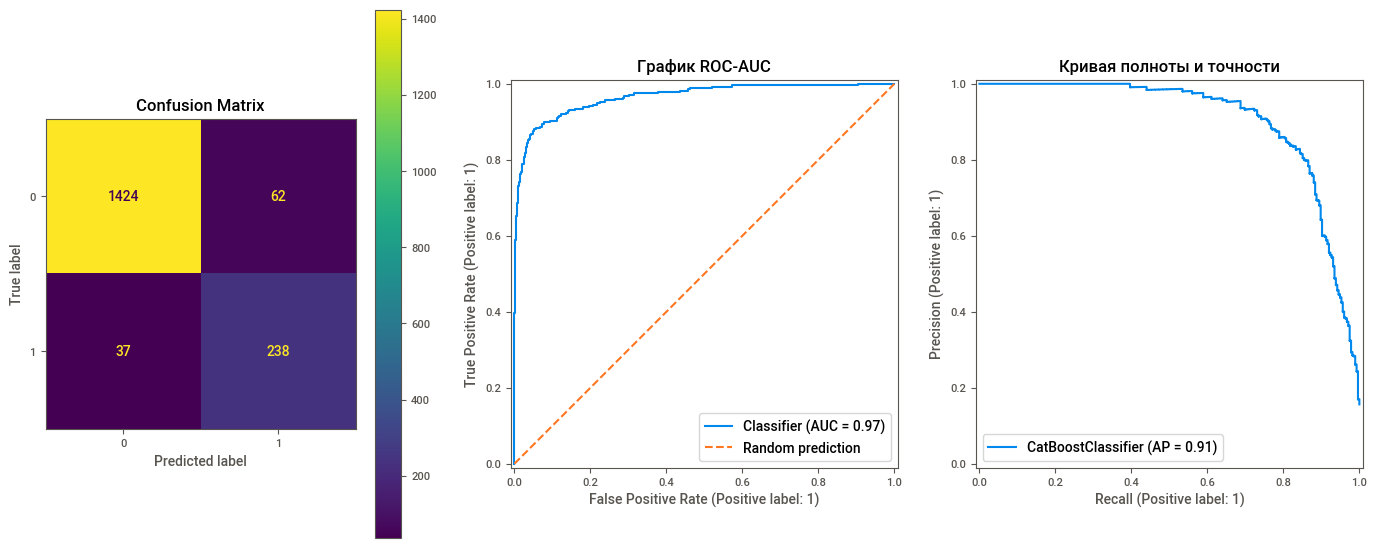

In [64]:
model_score(best_cat, X_test, y_test)

**Промежуточные выводы:**
- метрика соответствует ТЗ и выглядит очень хорошо ROC-AUC =  0.97 -  модель отлично справляется с разделением классов,
- Accuracy  =  0.94 -  модель правильно классифицирует около 94% всех объектов,
- правильно идентифицировала 96% всех клиентов пролонгирующих договор,
- правильно идентифицировала 87% все клиентов расторгающих договор,
- лишь 13% недовольных клиентов остались незамеченными (37 догворов) и 4% неправильно иденцифицировали как недовольных (62 человека)
- Успех!

### Важность признаков

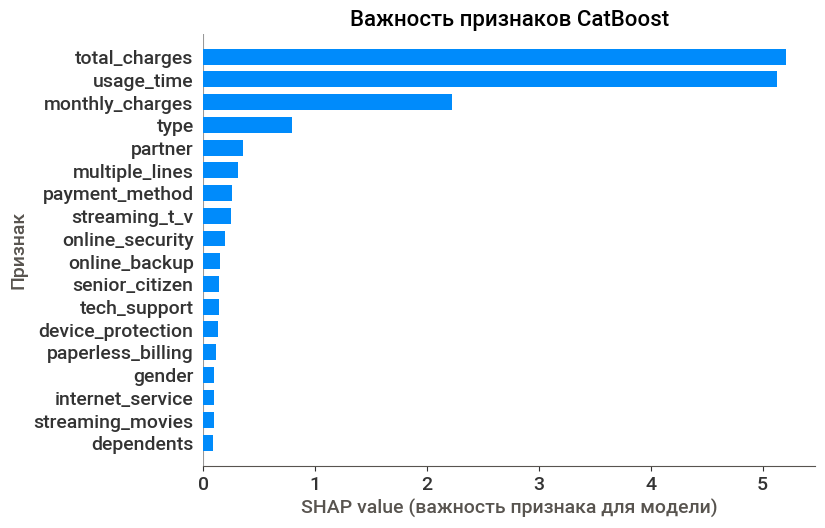

In [65]:
explainer = shap.Explainer(best_cat)
shap_values = explainer.shap_values(X_test)
 
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size= 0.2, show=False, cmap='summer')
fig, ax = plt.gcf(), plt.gca()
# Настройка подписей
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (важность признака для модели)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность признаков CatBoost', fontsize=16)

plt.show()

Модель считает самым важным общее количетво платежей кдиента иобщее время взаимодействия с компанией, так же важны месячный платеж и тип подключния интернета. Выглядит весьма логично.

## Выводы по проекту

### Выводы о проделанной работе:
- в БД найдены все 4 искомые таблицы;
- данные корректно загружены;
- проведен первичный анализ данных при помощи библиотеки sweetvis:
    - явные дубликаты не обнаружены;
    - установлены пропуски в некотрых признаках;
    - рассмотрено общее распределение признаков;
- создан общий датасет для моделирования и проведен исследовательский анализ признаков:
    - корректно заполнены пропуски и обработаны даты,
    - добавлен новый признак - длительность договоа,
    - определен целевой признак - расторжение договора,
    - проанализировано влияние признаков на целевую переменную:
        - выявлено влияние стоимости договора и его длительность, кроме того чаще расторгают договора пенсионеры и семейные пользователи, пользующиеся доп.услугами,
    - мульколлинеарность между некоторыми из признаков присутствует, но было принято решение ее не устранять;
- данные разбиты на обучающую и тестовую выборки;
- рассмотрены 3 модели(лес, бустинг и нейросеть):
     - лучшие результаты показала модель  CatBoostClassifier{'depth': 2, 'iterations': 1700, 'learning_rate': 0.4},
- лучшая модель протестирована:
     - результат соответствует требованиям ТЗ ROC_AUC>0.85:
         -  ROC-AUC =  0.97 -  модель отлично справляется с разделением классов,
         - Accuracy  =  0.94 -  модель правильно классифицирует около 94% всех объектов,
         - правильно идентифицировала 96% всех клиентов пролонгирующих договор,
         - правильно идентифицировала 87% все клиентов расторгающих договор,
         - лишь 13% недовольных клиентов остались незамеченными (37 догворов) и 4% неправильно иденцифицировали как недовольных (62 человека)
- выявлены наиболее важные для модели признаки:
    - общее количетво платежей клиента,
    - общее время взаимодействия с компанией,
    - так же важны месячный платеж и тип подключния интернета.
### Дальнейшие рекомендации:
- возможно доработать имеющуюся модель создав новые признаки из имеющихся(акцентировать внимание на доп.услугах),
- в целом я стараляс полобрать модель что б взвешенно минимизировать ошибку,  отловив всех уходящих(класс 1) но при этом не увеличив ошибку предсказания класса 0, но можно еще рассмотреть вариант с порогами классификации,
- для бизнеса рекомендуется рассмотреть внимательнее договорную систему 2х летней оплаты - актуальны ли цены для клиентов(эта категория чаще расторгается);
- мониторинг качества доп услуг - клиенты предпочитающие доп.услуги уходят чаще,
- так же возможно предложить возможные доп. скидки или услуги для пенсионного и семейного сегмента.